Priorities:
Way to get distribution of yards so that stats can be applied to results of play
Defensive players in the box
3-4/ 4-4 defense
Ball Carriers
    Punch in ball on one yard line with defensive player
    QB runs vs sacking plays
Angle of movement by player
Prediction of running impacted players
Distance from yard line
    What happens when there was a flag. So team is 15/20 yards away
Size of gaps
Team stats and matchup stats
Players kneeling


Possibile Features:
    Rusher
        X
        S
            Horizontal
            Vertical
        A
        Dis
        Orientation
        NflId
        mean_yards_season
        mean_yards
    Defense
        DefendersInTheBox
            Centroid
            Radius
            Largest Gap
                Horizontal
                Vertical
            Spread Y
        DL
        LB
    Offense
        OffenseFormation
        RB
        TE
        WR
    YardLine
    Quarter
    Down
    Distance
    Position
    min_time_to_tackle
    is_first_and_ten
    num_defense_x_distance_away
    num_team_members_in_hole
    is_going_wide
    is_going_for_goal
    is_first_and_ten
    distance_to_QB
    players_in_cone_of_movement
    num_defense_matched
    num_defense_in_the_hole_matched
    distance_to_los
    

In [2]:
import os
import datetime

import pandas as pd
pd.set_option('max_columns', 100)
import numpy as np
import math
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
train_df = pd.read_csv('../resources/train.csv', low_memory=False)
train_df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [6]:
# Function to make the plays always attack from left to right
class PlayClass:
    def __init__(self, nfl):
        self.nfl = nfl
        self._normalise_starting_df()
        self.rushers = self.nfl.loc[self.nfl.NflId == self.nfl.NflIdRusher]
        
    def _normalise_starting_df(self):
        self._fix_team_abbr()
        self._fix_orientation()
        self._fix_speed()
        self._add_possession_columns()
        self._flip_left_plays()
        self._distance_to_centers()
        self.nfl['IsFirstAndTen'] = 1
        self.nfl.loc[(self.nfl.Distance != 10.0) | (self.nfl.Down != 1), 'IsFirstAndTen'] = 0

    def _fix_team_abbr(self):
        map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
        for abb in self.nfl['PossessionTeam'].unique():
            map_abbr[abb] = abb
        self.nfl['PossessionTeam'] = self.nfl['PossessionTeam'].map(map_abbr)
        self.nfl['HomeTeamAbbr'] = self.nfl['HomeTeamAbbr'].map(map_abbr)
        self.nfl['VisitorTeamAbbr'] = self.nfl['VisitorTeamAbbr'].map(map_abbr)

    def _fix_orientation(self):
        self.nfl.loc[self.nfl['Season'] == 2017, 'Orientation'] \
            = np.mod(90 + self.nfl.loc[self.nfl['Season'] == 2017, 'Orientation'], 360)
        self.nfl['Orientation'] = (self.nfl['Orientation'] * math.pi / 180) - math.pi

    def _fix_speed(self):
        self.nfl['S_std'] = self.nfl['S']
        self.nfl.loc[self.nfl['Season'] == 2017, 'S'] \
            = (self.nfl['S'][self.nfl['Season'] == 2017] - 2.4355) / 1.2930 * 1.4551 + 2.7570

    def _flip_left_plays(self):
        self.nfl['ToLeft'] = self.nfl.PlayDirection == "left"
        self.nfl['YardLine_std'] = 100 - self.nfl.YardLine
        self.nfl.loc[self.nfl.FieldPosition.fillna('') == self.nfl.PossessionTeam, 'YardLine_std'] \
            = self.nfl.loc[self.nfl.FieldPosition.fillna('') == self.nfl.PossessionTeam, 'YardLine']

        self.nfl['X_std'] = self.nfl.X
        self.nfl.loc[self.nfl.ToLeft, 'X_std'] = 120 - self.nfl.loc[self.nfl.ToLeft, 'X']
        self.nfl['Y_std'] = self.nfl.Y - 160 / 6
        self.nfl.loc[self.nfl.ToLeft, 'Y_std'] = 160 / 6 - self.nfl.loc[self.nfl.ToLeft, 'Y']
        self.nfl.loc[self.nfl['Y_std'] >= 160 / 6, 'Y_std'] = 26.6

        self.nfl['Dir_rad'] = np.mod(90 - self.nfl.Dir, 360) * math.pi / 180.0
        self.nfl['Dir_std'] = self.nfl.Dir_rad
        self.nfl.loc[self.nfl.ToLeft, 'Dir_std'] = np.mod(np.pi + self.nfl.loc[self.nfl.ToLeft, 'Dir_rad'], 2 * np.pi)
        self.nfl['Dir_std'] = self.nfl['Dir_std']  - math.pi

    def _add_possession_columns(self):
        self.nfl['IsRusher'] = self.nfl.NflId == self.nfl.NflIdRusher
        self.nfl['TeamOnOffense'] = "home"
        self.nfl.loc[self.nfl.PossessionTeam != self.nfl.HomeTeamAbbr, 'TeamOnOffense'] = "away"
        self.nfl['IsOnOffense'] = self.nfl.Team == self.nfl.TeamOnOffense

    def _distance_to_centers(self):
        self.nfl['DisFromPlayStart'] = np.sqrt(
            (self.nfl.X_std - self.nfl.YardLine_std - 10) ** 2 + (self.nfl.Y_std ** 2))
        ranks = self.nfl.groupby(['PlayId', 'IsOnOffense'])['DisFromPlayStart'] \
            .rank(ascending=True, method='first')
        ranks.name = 'RankDisFromPlayStart'
        self.nfl = pd.concat([self.nfl, ranks], axis=1)
        self.nfl['IsDefenderInBox'] = False
        self.nfl.loc[(~self.nfl.IsOnOffense) &
                     (self.nfl.DefendersInTheBox >= self.nfl.RankDisFromPlayStart), ['IsDefenderInBox']] = True


pc = PlayClass(pd.read_csv('../resources/train.csv', low_memory=False))
train_df = pc.nfl
rusher_df = pc.rushers

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 63 columns):
GameId                    509762 non-null int64
PlayId                    509762 non-null int64
Team                      509762 non-null object
X                         509762 non-null float64
Y                         509762 non-null float64
S                         509762 non-null float64
A                         509762 non-null float64
Dis                       509762 non-null float64
Orientation               509744 non-null float64
Dir                       509748 non-null float64
NflId                     509762 non-null int64
DisplayName               509762 non-null object
JerseyNumber              509762 non-null int64
Season                    509762 non-null int64
YardLine                  509762 non-null int64
Quarter                   509762 non-null int64
GameClock                 509762 non-null object
PossessionTeam            509762 non-null object
Down   

In [7]:
def ends(df, x=5):
    return df.head(x).append(df.tail(x))

avg_dis= train_df.query('NflIdRusher == NflId').groupby('DisplayName')[['Yards','DisplayName']].mean().sort_values(by=['Yards'])
ends(avg_dis)

,Yards
DisplayName,
Josh Doctson,-14.0
Rod Streater,-11.0
Antonio Callaway,-8.0
Josh Hill,-8.0
DeAndre Hopkins,-7.0
Marqise Lee,17.0
Jarius Wright,19.5
DJ Moore,20.6
Darren Waller,21.0


(-10, 30)

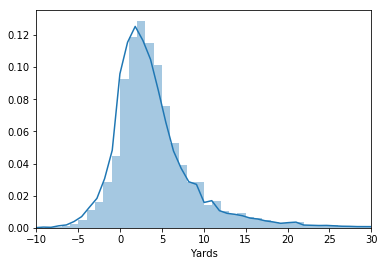

In [8]:
sns.distplot(train_df.query('NflIdRusher == NflId')['Yards'], bins = np.arange(-99, 99, 1))
plt.xlim(-10, 30)

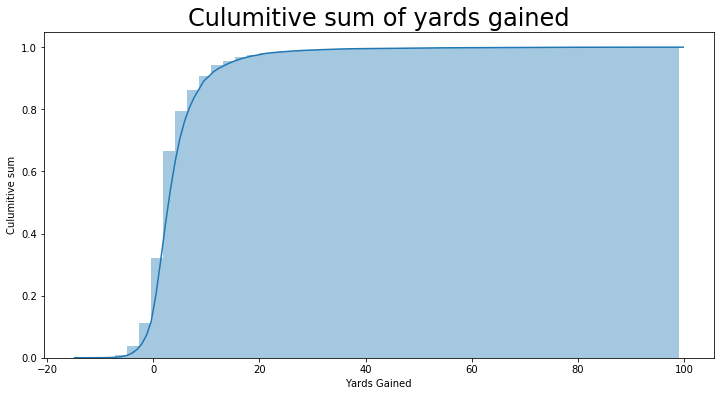

In [9]:
plt.figure(figsize=(12, 6))
sns.distplot(train_df["Yards"],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
plt.xlabel('Yards Gained')
plt.ylabel('Culumitive sum')
plt.title('Culumitive sum of yards gained', fontsize=24)
plt.show()

In [10]:
train_df['GameId'].value_counts().head()

2017121000    1870
2017101501    1628
2017100108    1452
2017092100    1386
2017091002    1386
Name: GameId, dtype: int64

## Displaying of players
 Using the code from this notebook. It is a simple solution to displaying the players. 
 And the time spent making it can be put to better use
 https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position


1.5428710587629875


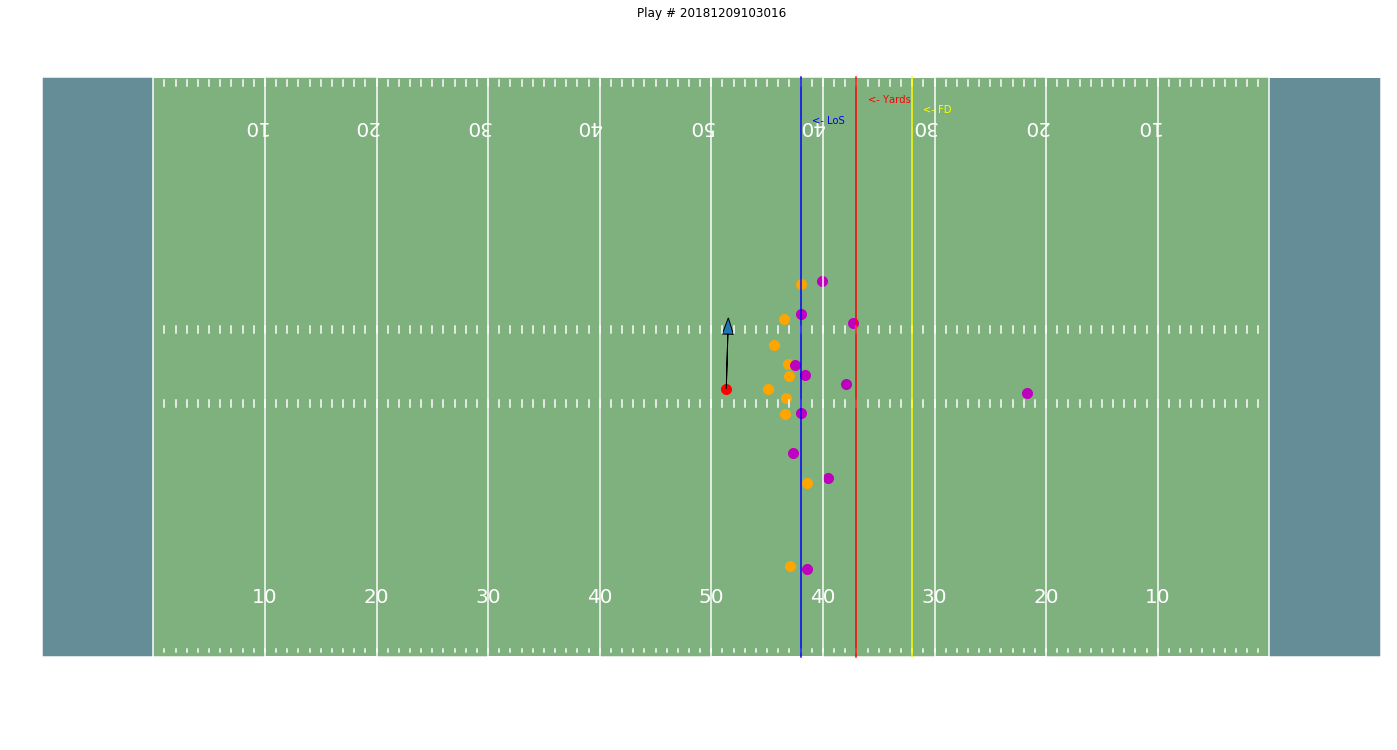

In [7]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          field_lines=False,
                          field_lines_numbers=[20,30,25],
                          fifty_is_los=False,
                          figsize=(12*2, 6.33*2)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0,  alpha=0.5)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if field_lines:
        colours = ['blue', 'yellow', 'red']
        text = ['LoS', 'FD', 'Yards']
        for i in range(len(field_lines_numbers)):
            line = field_lines_numbers[i] + 10
            plt.plot([line, line], [0, 53.3], color=colours[i])
            plt.text(line + 1, 49 + i, '<- {}'.format(text[i]),
                     color=colours[i])
        
    return fig, ax

def plot_runner(runner_df, ax):
    x = runner_df['X_Std'].values[0]
    y = runner_df['Y_Std'].values[0]
    rad = (runner_df['Dir_std'].values[0] + math.pi)
    print(rad)
    dx = math.cos(rad) * 5
    dy = math.sin(rad) * 5
    runner_df.plot(x='X_Std', y='Y_Std', kind='scatter', ax=ax, color='red', s=100, legend='Rusher')
    ax.arrow(x=x, y=y, dx=dx, dy=dy, head_width=1)

def get_yard_lines(rusher_df):
    yl = rusher_df['YardLine'].tolist()[0]
    if rusher_df['FieldPosition'].tolist() != rusher_df['PossessionTeam'].tolist():
        yl = 100 - yl
    fd = yl + rusher_df['Distance'].tolist()[0]
    yg = yl + rusher_df['Yards'].tolist()[0]
    return yl, fd, yg

def display_play(playid):
    rusher_df = train_df.query("PlayId == @playid and NflIdRusher == NflId")
    rusher_df['Y_Std'] = rusher_df['Y_std'] + 26.67
    rusher_df['X_Std'] = rusher_df['X_std']
    yl, fd, yg = get_yard_lines(rusher_df)
    fig, ax = create_football_field(field_lines=True,
                                    field_lines_numbers=[yl, fd, yg])
    plot_runner(rusher_df, ax)
    train_df['Y_Std'] = train_df['Y_std'] + 26.67
    train_df['X_Std'] = train_df['X_std']
    train_df.query("PlayId == @playid and Team == 'away' and NflIdRusher != NflId") \
        .plot(x='X_Std', y='Y_Std', kind='scatter', ax=ax, color='orange', s=100, legend='Away')
    train_df.query("PlayId == @playid and Team == 'home' and NflIdRusher != NflId") \
        .plot(x='X_Std', y='Y_Std', kind='scatter', ax=ax, color='m', s=100, legend='Home')
    plt.title("Play # {}".format(playid))


playid = 20181209103016
display_play(playid)
plt.show() 

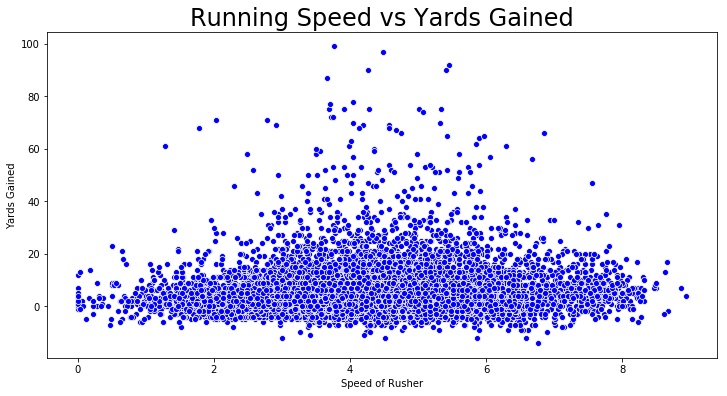

In [11]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='S', y='Yards', data=rusher_df, color='b')
plt.xlabel('Speed of Rusher')
plt.ylabel('Yards Gained')
plt.title('Running Speed vs Yards Gained', fontsize=24)
plt.show()

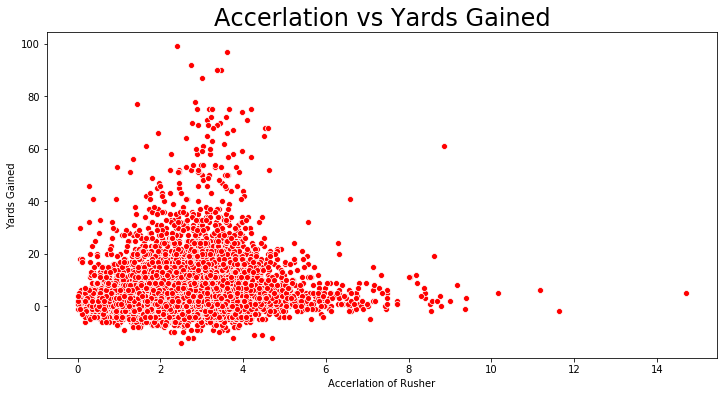

In [12]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='A', y='Yards', data=rusher_df, color='r')
plt.xlabel('Accerlation of Rusher')
plt.ylabel('Yards Gained')
plt.title('Accerlation vs Yards Gained', fontsize=24)
plt.show()

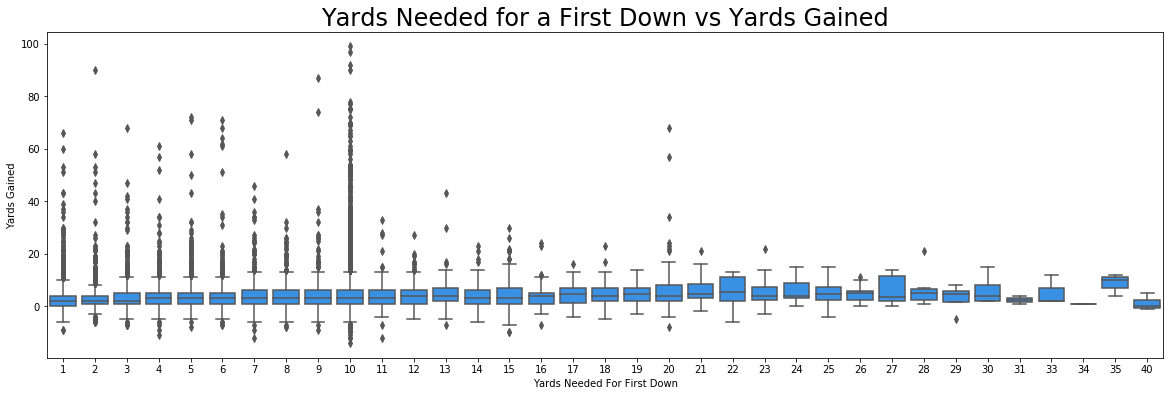

In [13]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='Distance', y='Yards', data=rusher_df, color='dodgerblue')
plt.xlabel('Yards Needed For First Down')
plt.ylabel('Yards Gained')
plt.title('Yards Needed for a First Down vs Yards Gained', fontsize=24)
plt.show()

# Defensive players in the Box

More defenders in the box means that the defense is trying to stop rushing type yards.

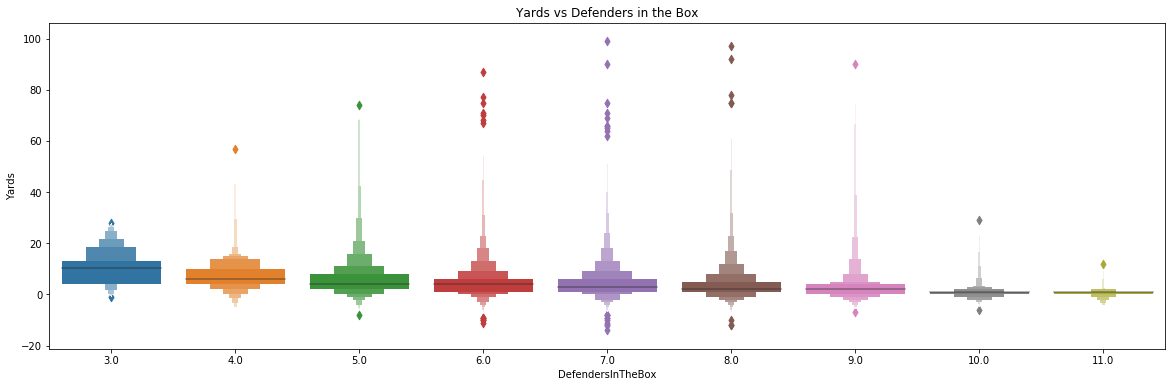

In [14]:
plt.figure(figsize=(20, 6))
sns.boxenplot(x='DefendersInTheBox',
               y='Yards',
               data=rusher_df.query('DefendersInTheBox > 2'))
plt.title('Yards vs Defenders in the Box')
plt.show()

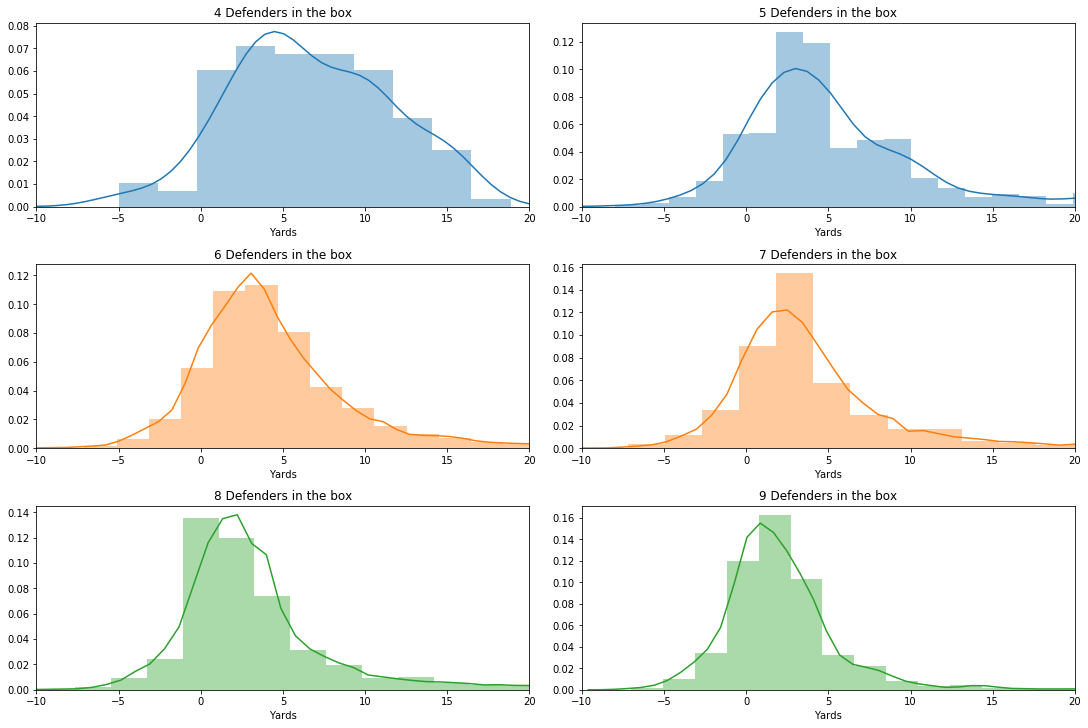

In [15]:
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

fig, axes = plt.subplots(3, 2, constrained_layout=True, figsize=(15 , 10))
#fig.tight_layout()
ax_idx = 0
ax_idx2 = 0
for i in range(4, 10):
    this_ax = axes[ax_idx2][ax_idx]
    #print(ax_idx, ax_idx2)
    sns.distplot(rusher_df.query('DefendersInTheBox == @i')['Yards'],
                ax=this_ax,
                color=color_pal[ax_idx2])
    this_ax.set_title('{} Defenders in the box'.format(i))
    this_ax.set_xlim(-10, 20)
    ax_idx += 1
    if ax_idx == 2:
        ax_idx = 0
        ax_idx2 += 1
plt.show()

In [16]:
rusher_df.groupby('DefendersInTheBox')[['DefendersInTheBox']].count()

,DefendersInTheBox
DefendersInTheBox,
1.0,1
2.0,1
3.0,18
4.0,118
5.0,684
6.0,6933
7.0,9478
8.0,4971
9.0,611


Obvious to see tat while there is signification yards made when defendersin the box are lower than 6 it doesn't happen as often. We can make an easy case in our model for these at first while focusing on the more common results. Such as 6-8 defenders in the box

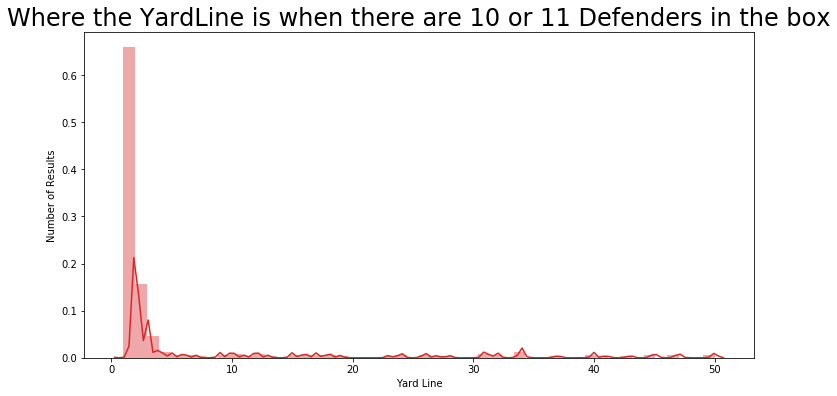

In [17]:
plt.figure(figsize=(12, 6))
sns.distplot(rusher_df.query('DefendersInTheBox >= 10')['YardLine'], color=color_pal[ax_idx2])
plt.xlabel('Yard Line')
plt.ylabel('Number of Results')
plt.title('Where the YardLine is when there are 10 or 11 Defenders in the box', fontsize=24)
plt.show()

As we can see when there are a lot of Defenders in the box it's most likely to stop the small gain near the field goal line

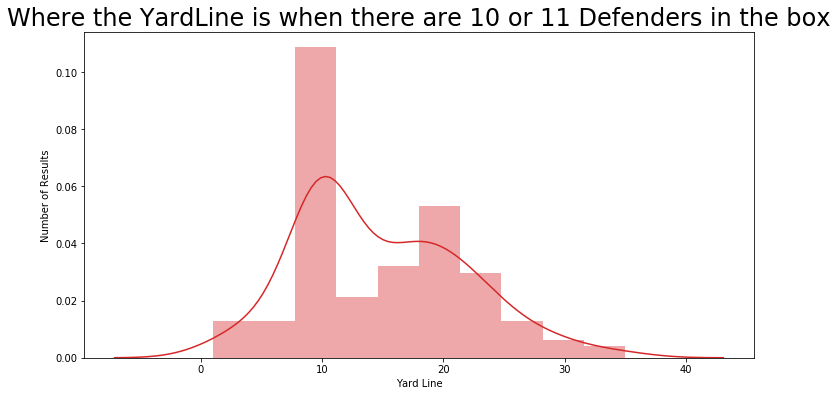

In [18]:
plt.figure(figsize=(12, 6))
sns.distplot(rusher_df.query('DefendersInTheBox <= 4')['Distance'], color=color_pal[ax_idx2])
plt.xlabel('Yard Line')
plt.ylabel('Number of Results')
plt.title('Where the YardLine is when there are 10 or 11 Defenders in the box', fontsize=24)
plt.show()

Most of the for when the defenders in the box are a small number is due to the offence is further away that than the usual 10 yards from first down. Therefore the defense will allow a rushing gain as it's unlikely that they'll get the first down

# Direction of Rushers
There's going to be a difference on how far a player will go based on if he is going out wide or through the middle
This could also be looked further by type of player

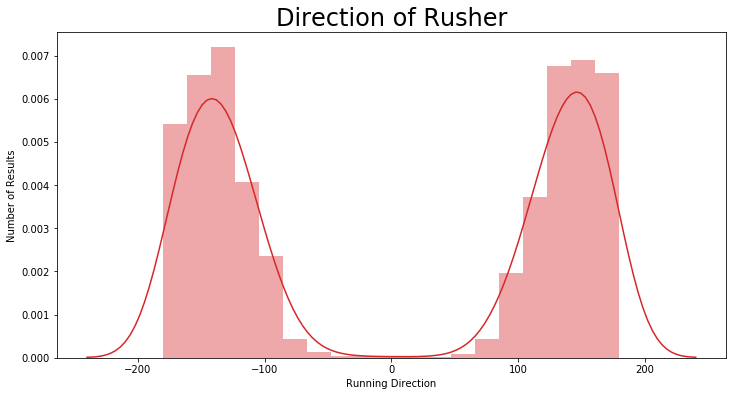

In [48]:
plt.figure(figsize=(12, 6))
sns.distplot(rusher_df['Dir_std'] * 180/math.pi, color=color_pal[ax_idx2])
plt.xlabel('Running Direction')
plt.ylabel('Number of Results')
plt.title('Direction of Rusher', fontsize=24)
plt.show()

In [20]:
rusher_df['Dir_Std_Centered'] = np.where(rusher_df['Dir_Std'] > 270, rusher_df['Dir_Std']-360, rusher_df['Dir_Std'])


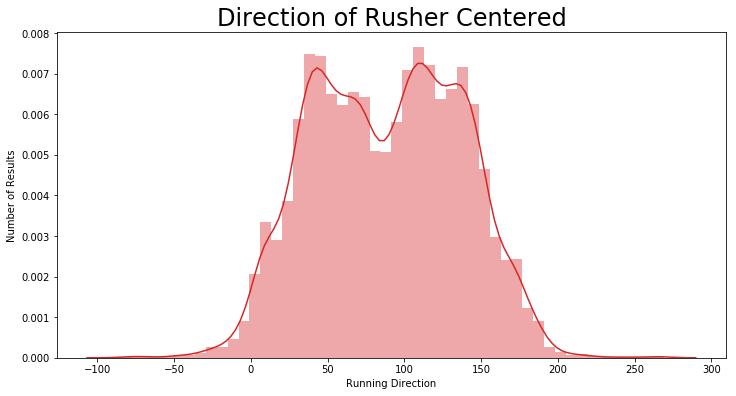

In [21]:
plt.figure(figsize=(12, 6))
sns.distplot(rusher_df['Dir_Std_Centered'], color=color_pal[ax_idx2])
plt.xlabel('Running Direction')
plt.ylabel('Number of Results')
plt.title('Direction of Rusher Centered', fontsize=24)
plt.show()

-2.5 -> 2.5, playid sample = 20170914001016


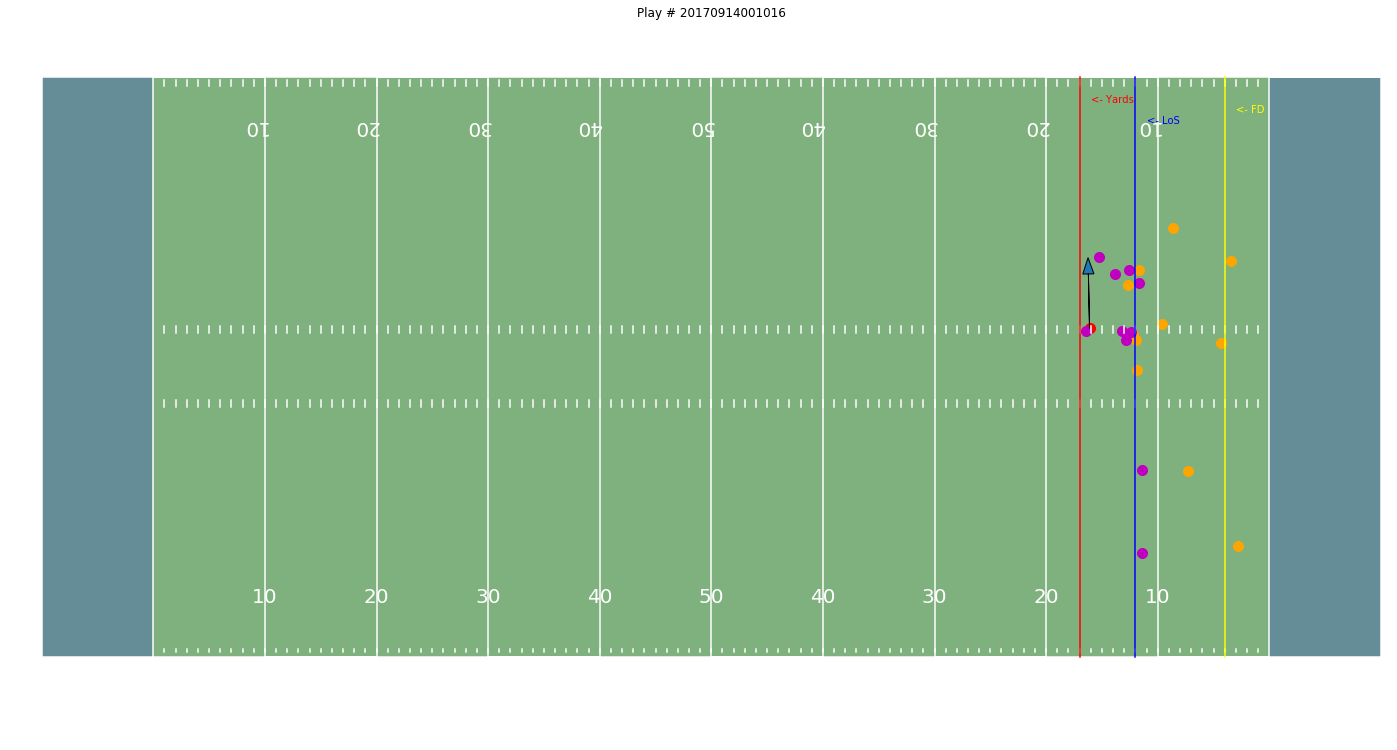

7.5 -> 12.5, playid sample = 20170907003507


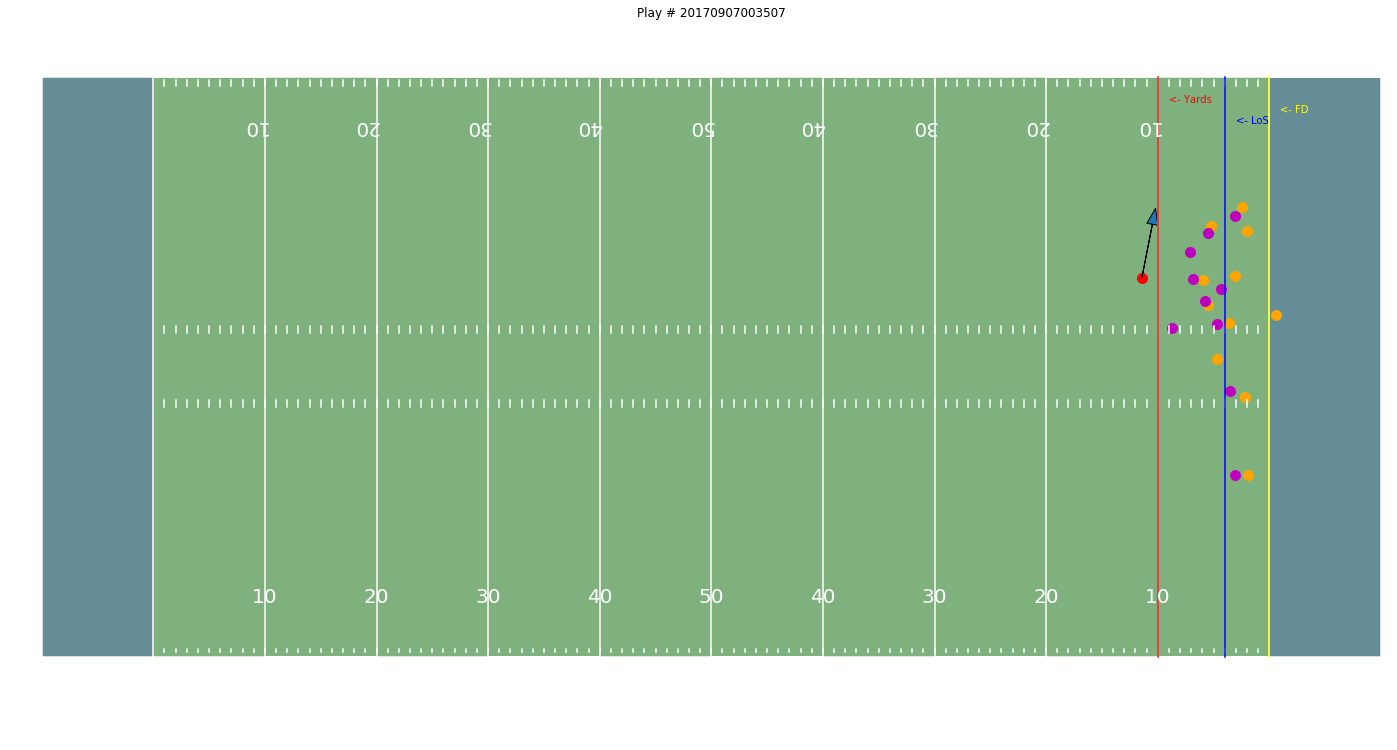

17.5 -> 22.5, playid sample = 20170907001509


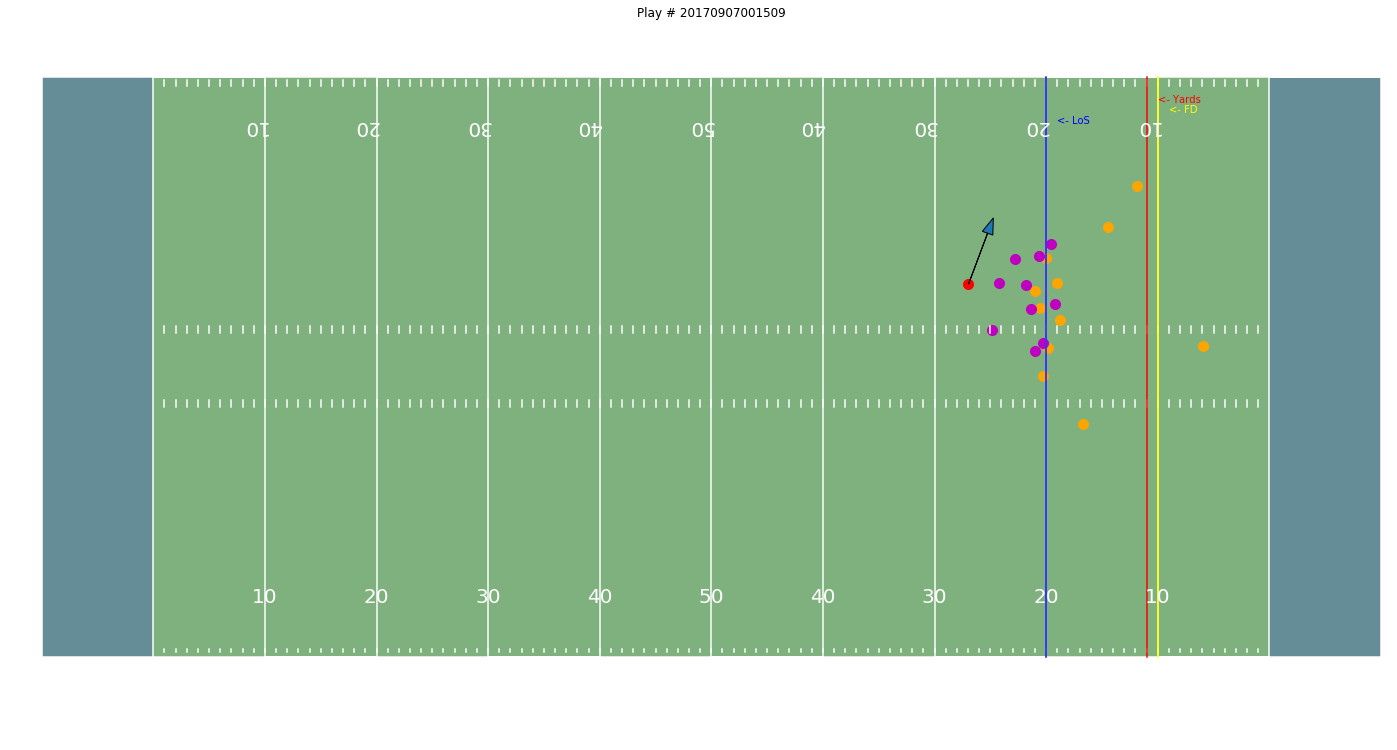

27.5 -> 32.5, playid sample = 20170907004046


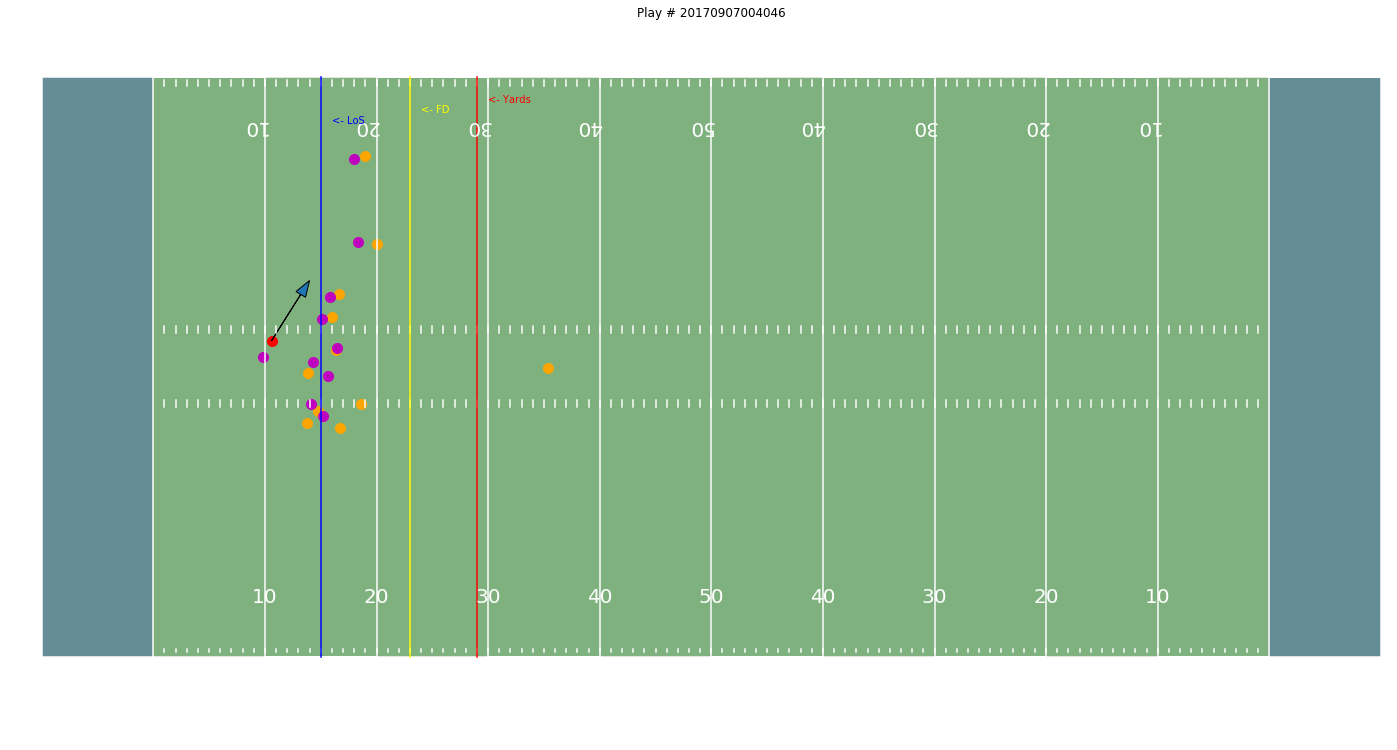

37.5 -> 42.5, playid sample = 20170907000189


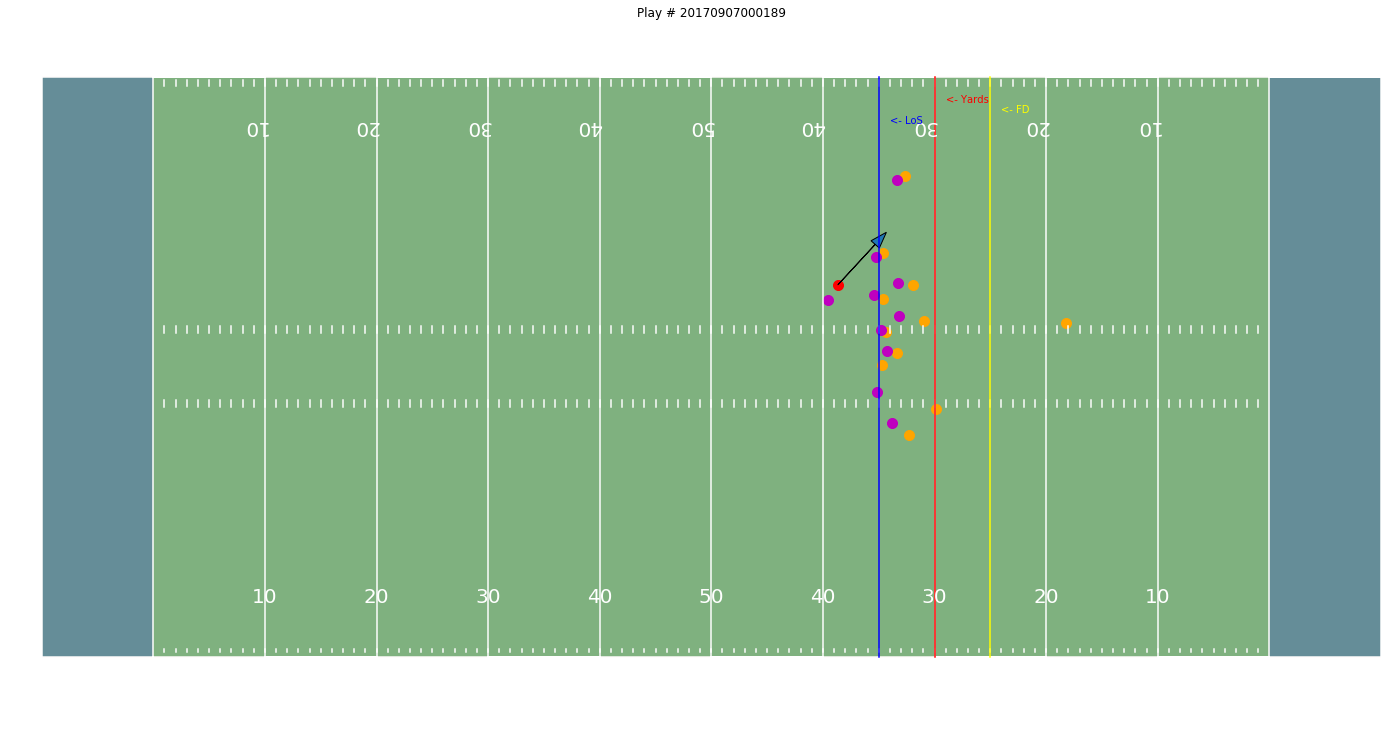

47.5 -> 52.5, playid sample = 20170910003233


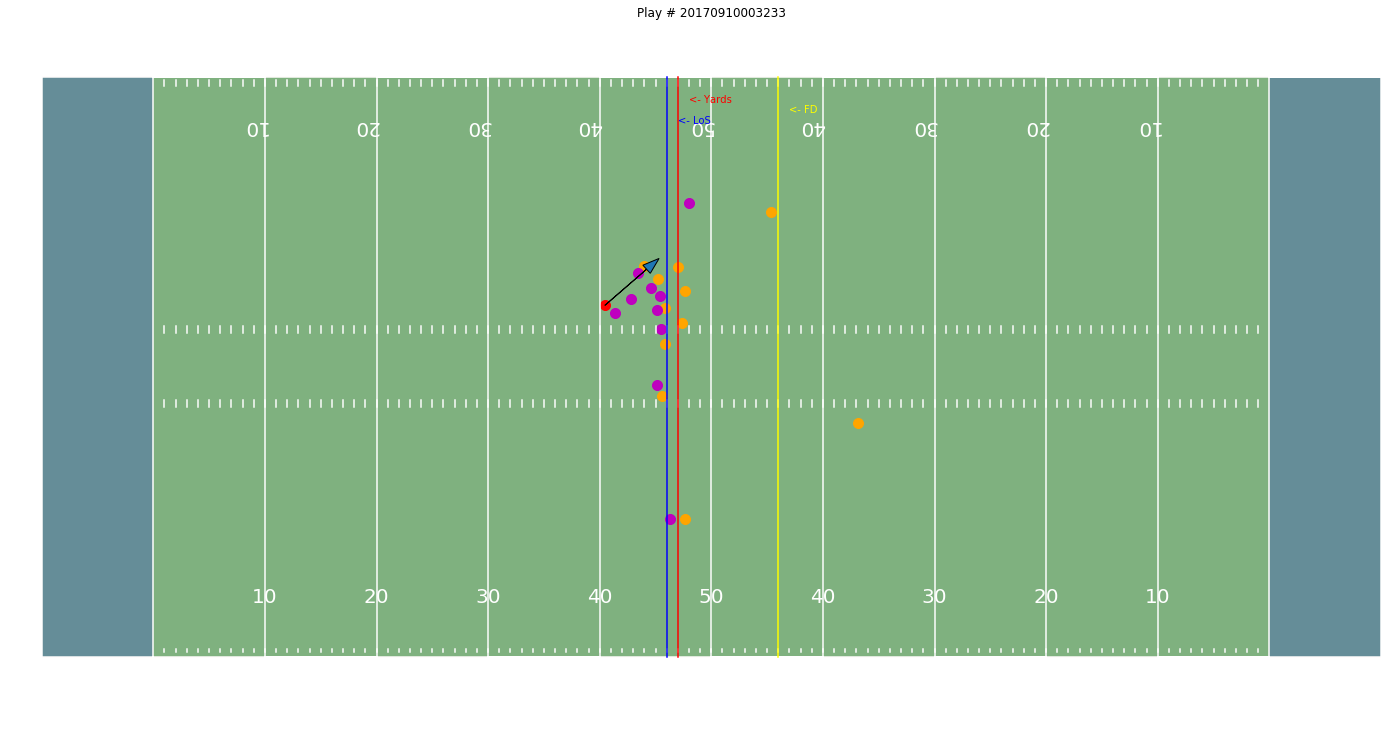

57.5 -> 62.5, playid sample = 20170907004182


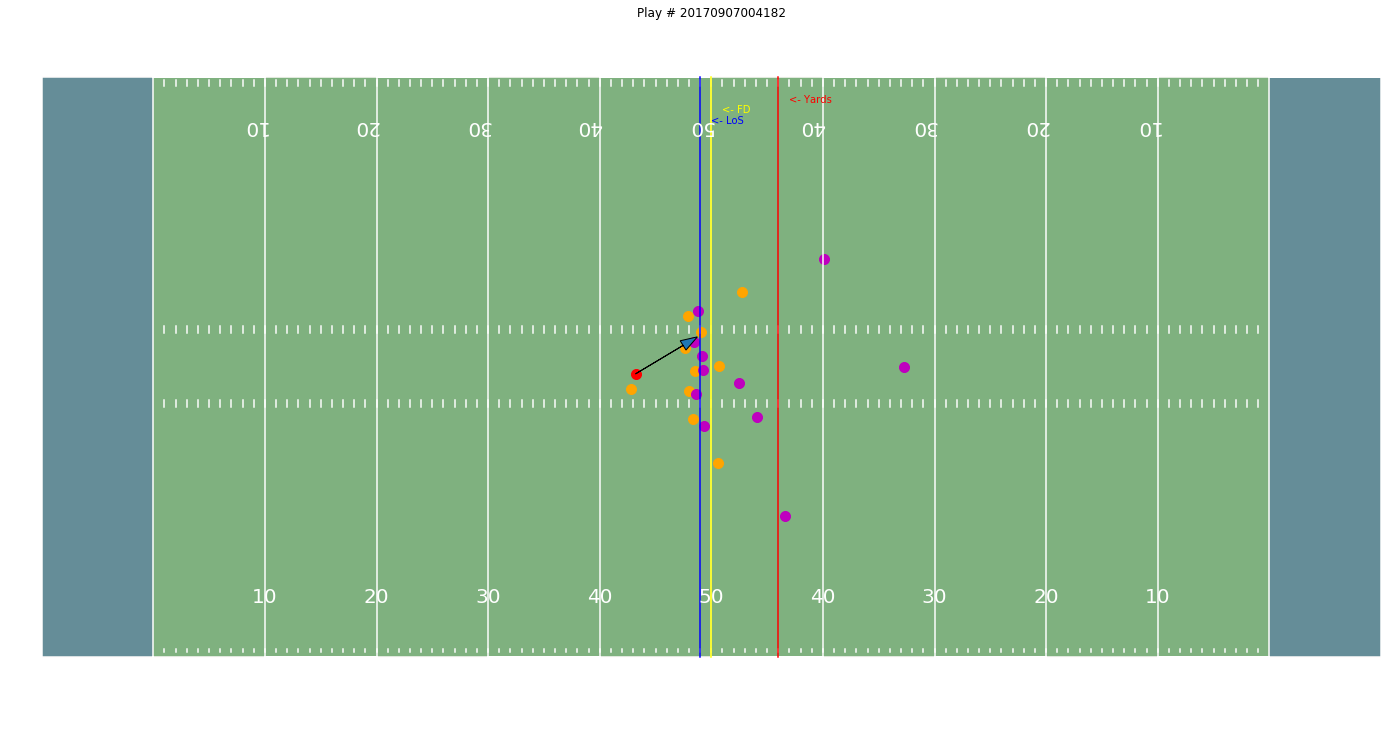

67.5 -> 72.5, playid sample = 20170907001530


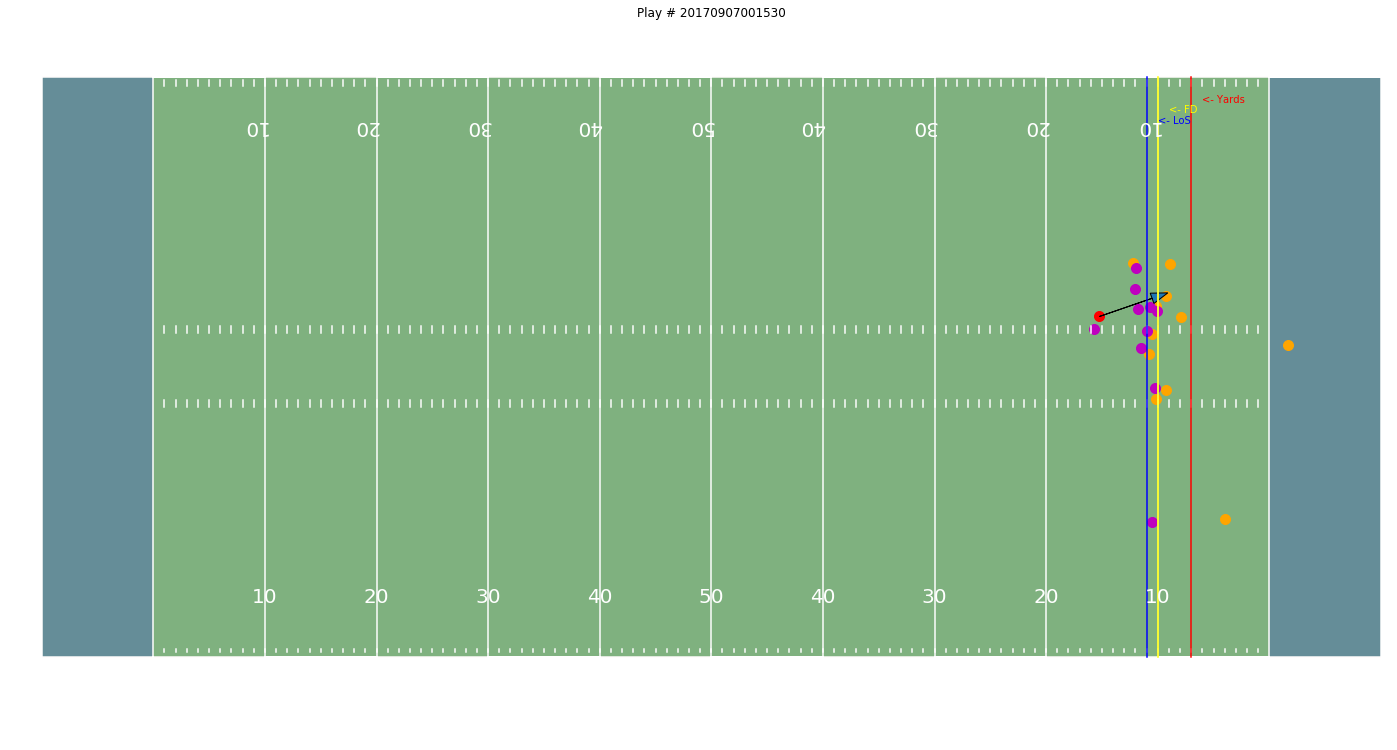

77.5 -> 82.5, playid sample = 20170910001622


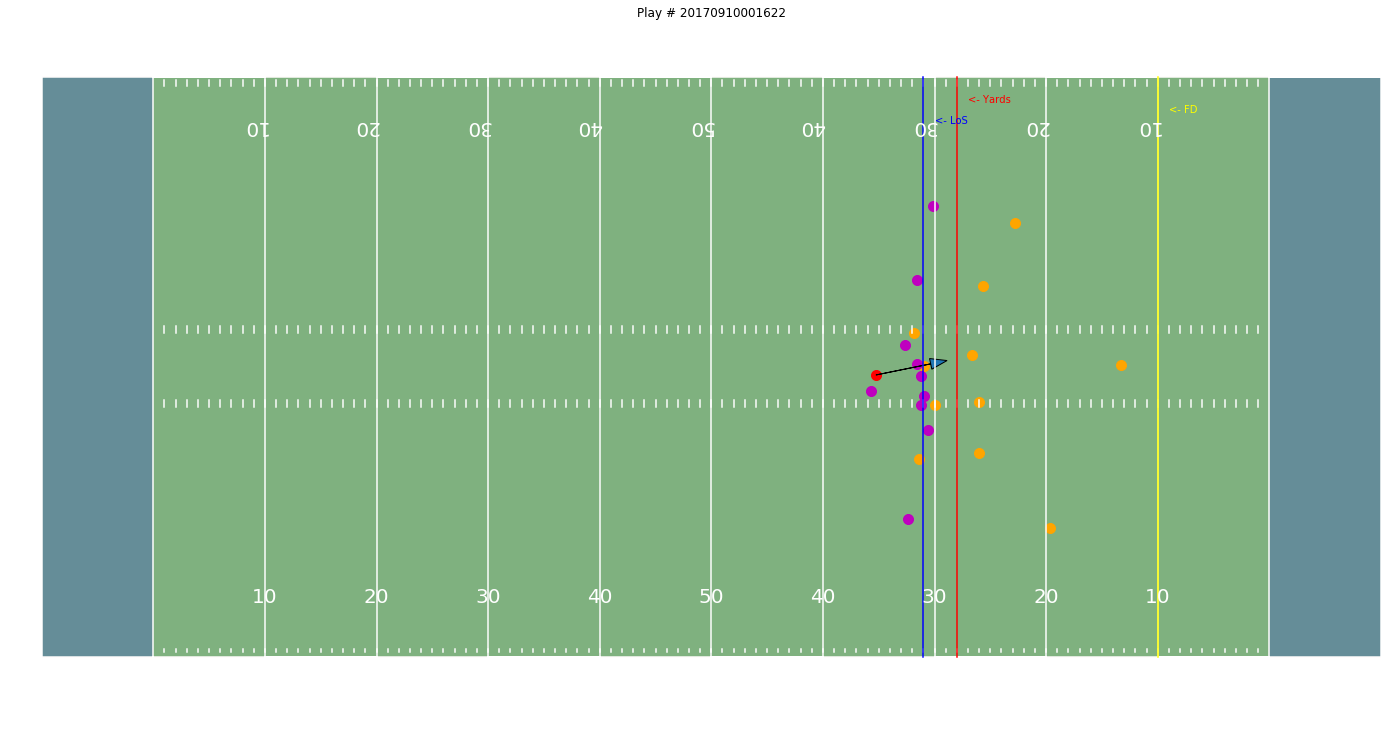

87.5 -> 92.5, playid sample = 20170907000917


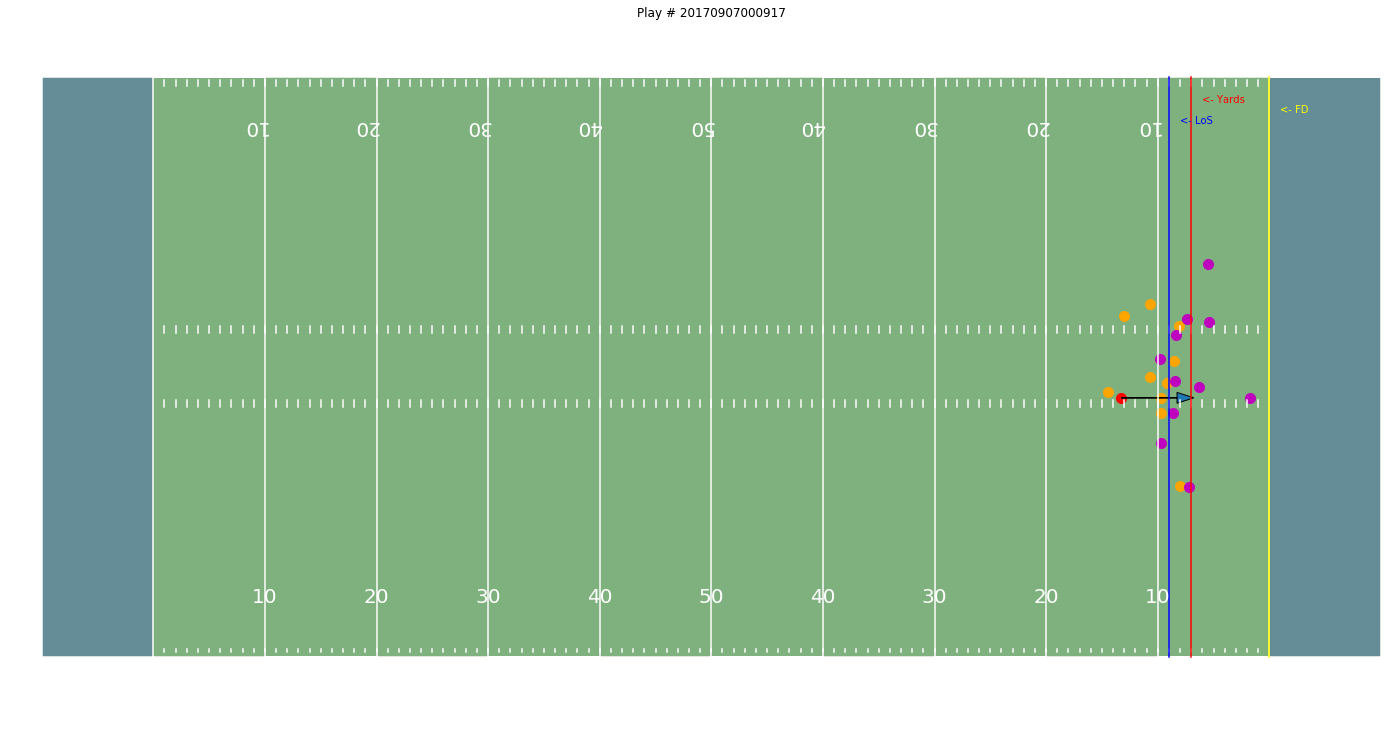

97.5 -> 102.5, playid sample = 20170907000653


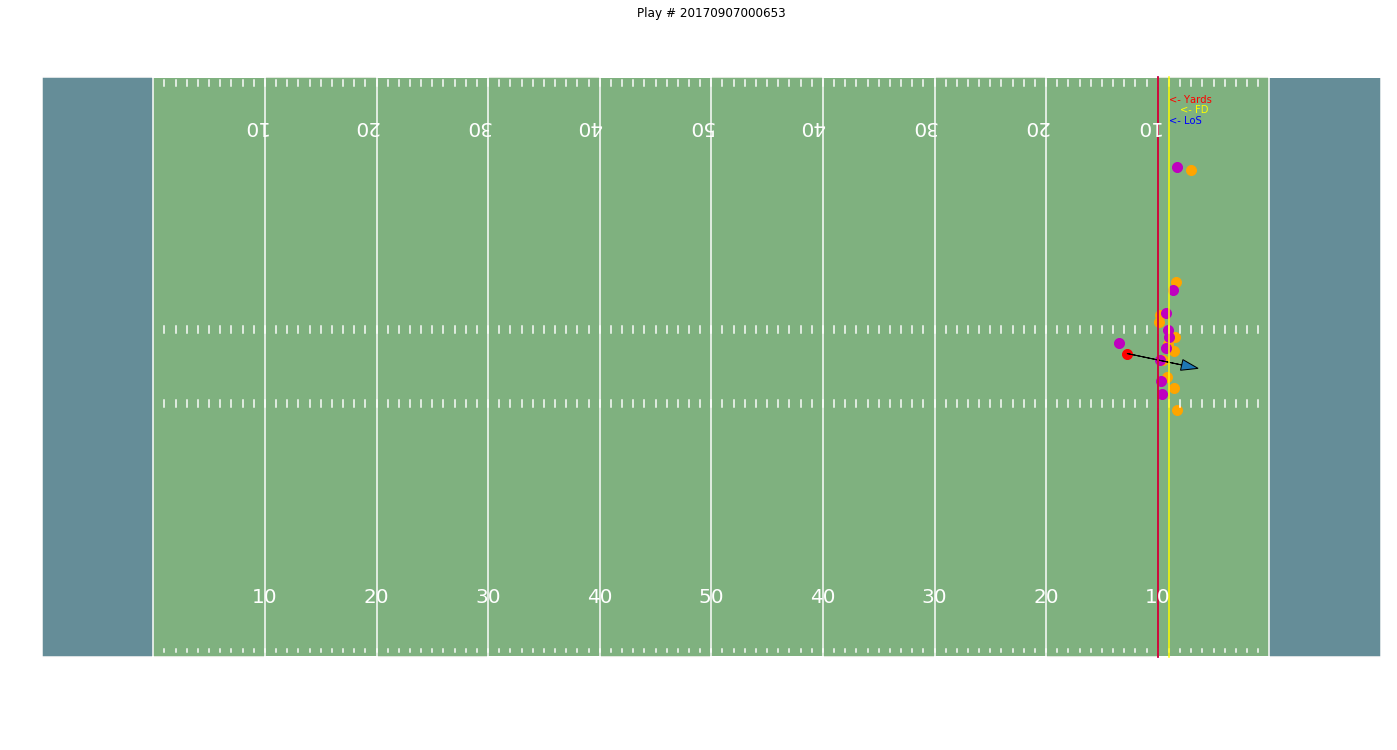

107.5 -> 112.5, playid sample = 20170907001177


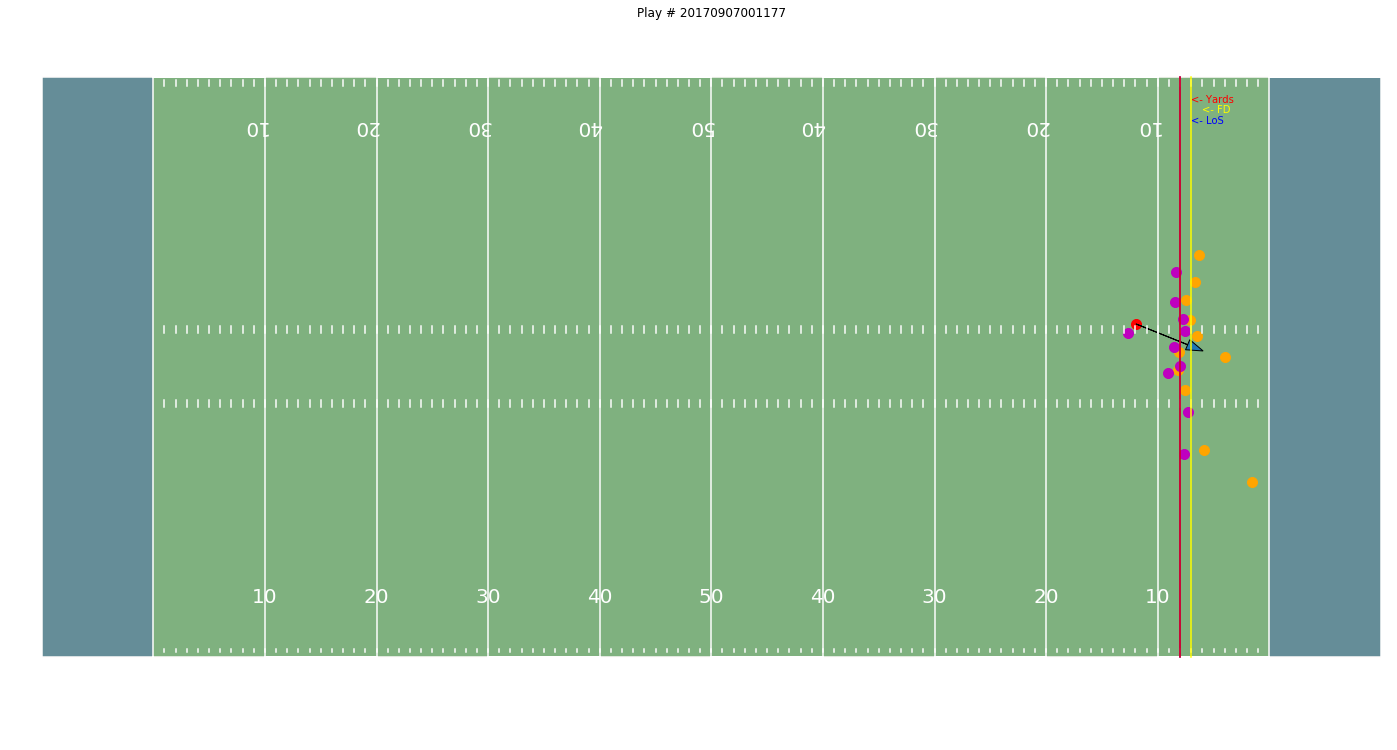

117.5 -> 122.5, playid sample = 20170907003138


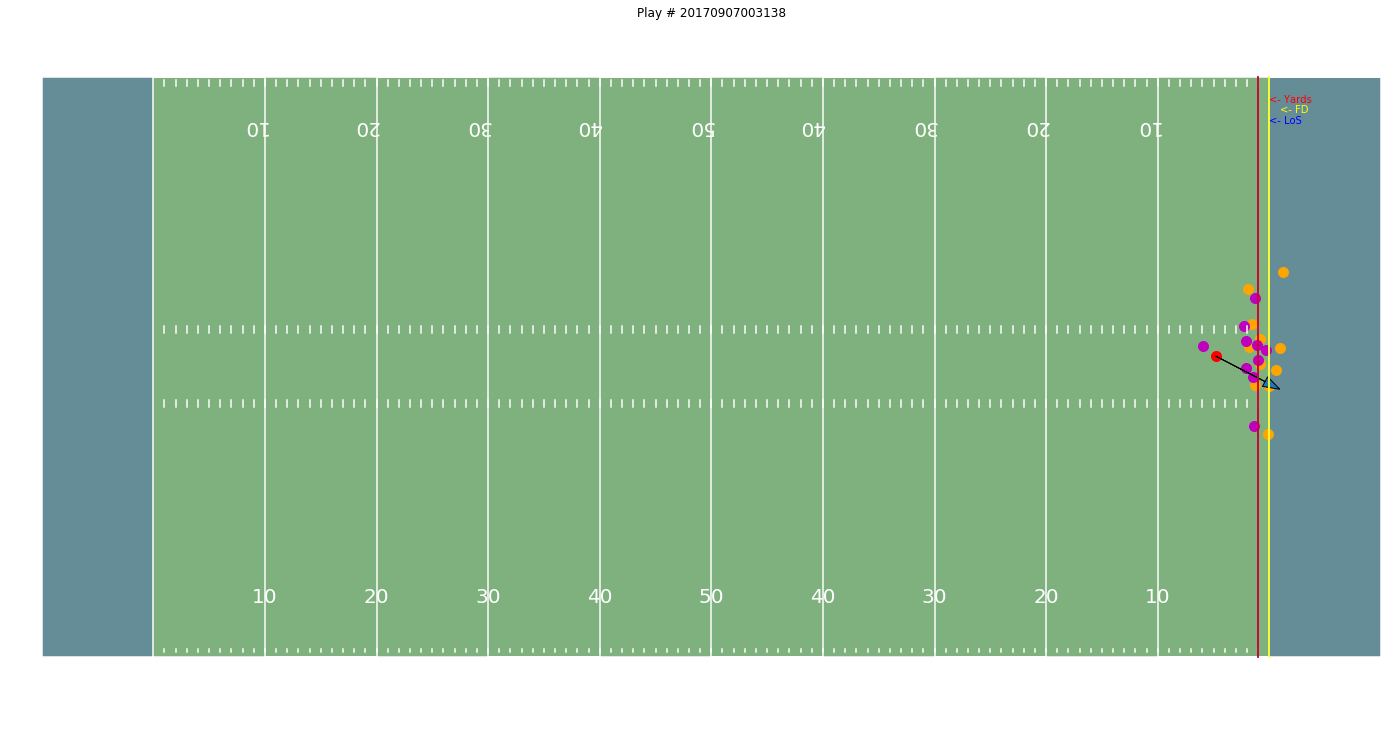

127.5 -> 132.5, playid sample = 20170907000139


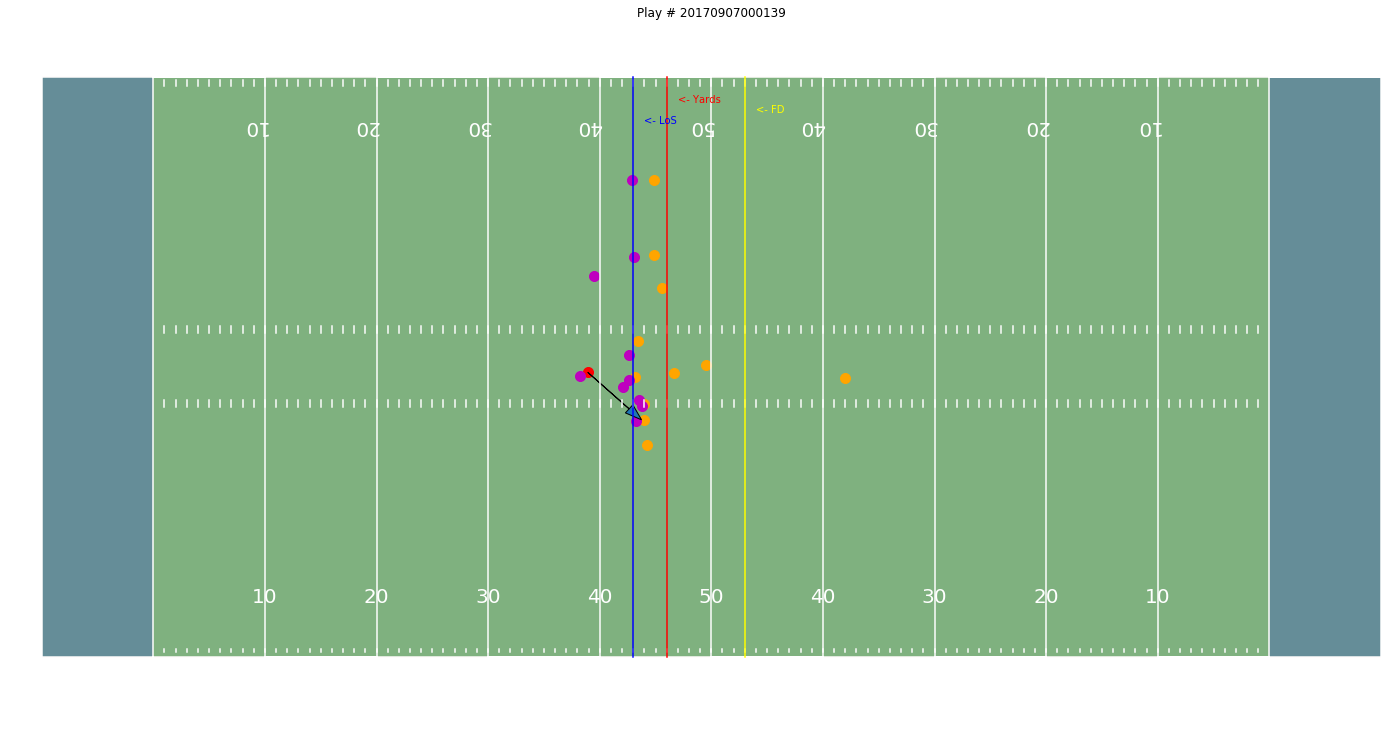

137.5 -> 142.5, playid sample = 20170907000473


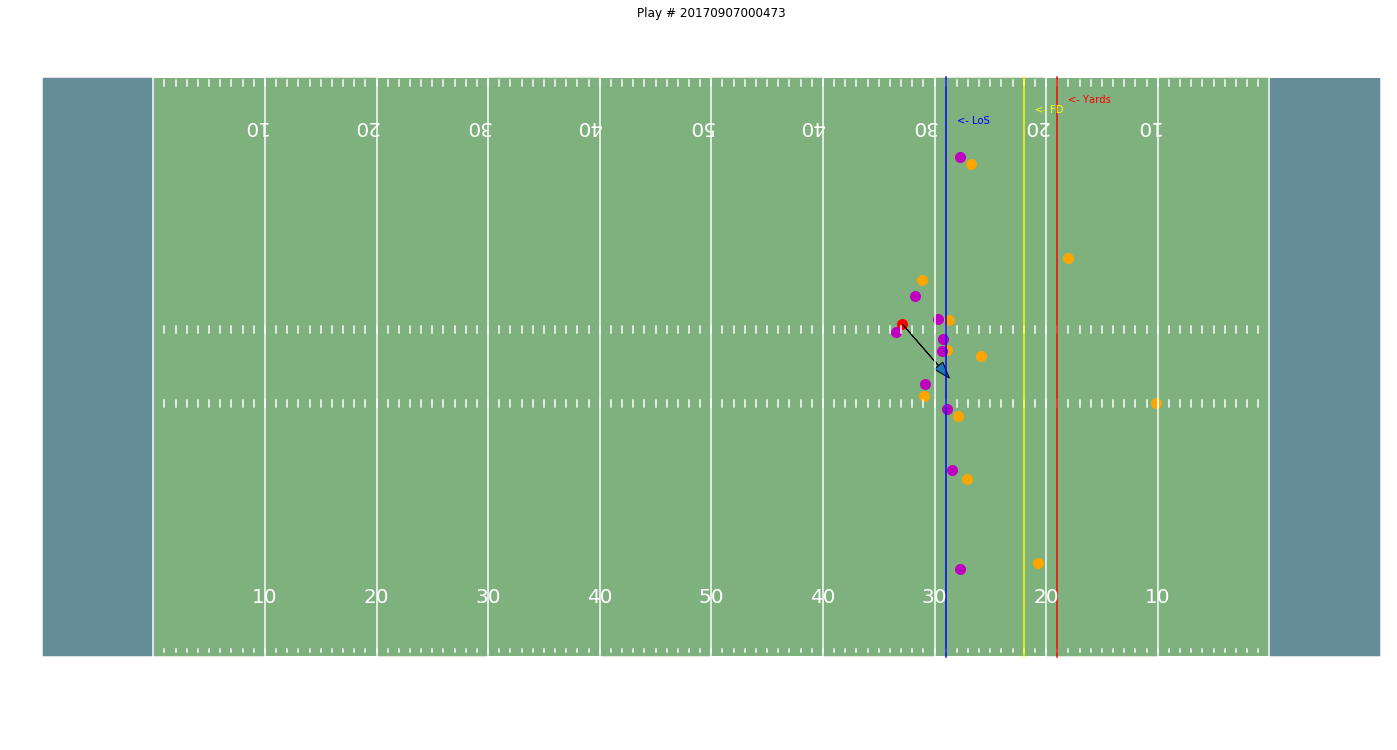

147.5 -> 152.5, playid sample = 20170910001543


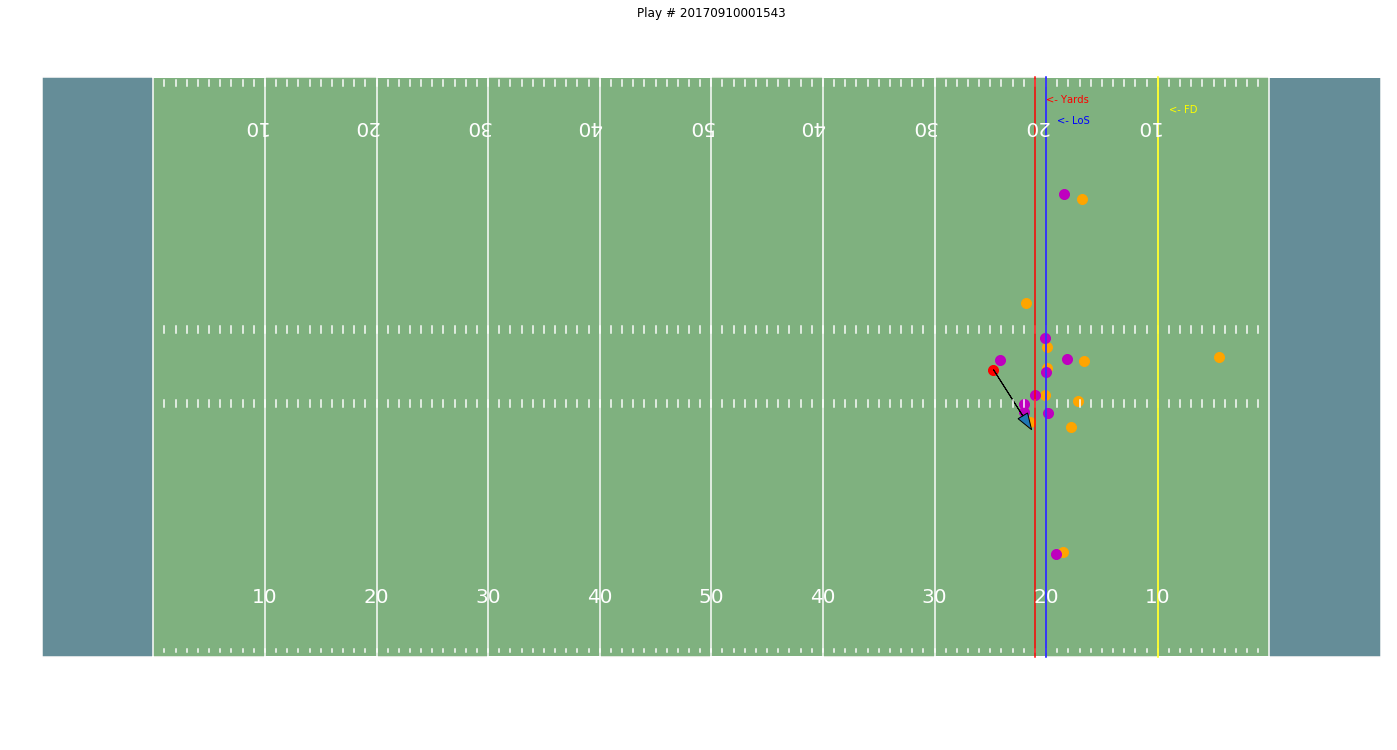

157.5 -> 162.5, playid sample = 20170907000395


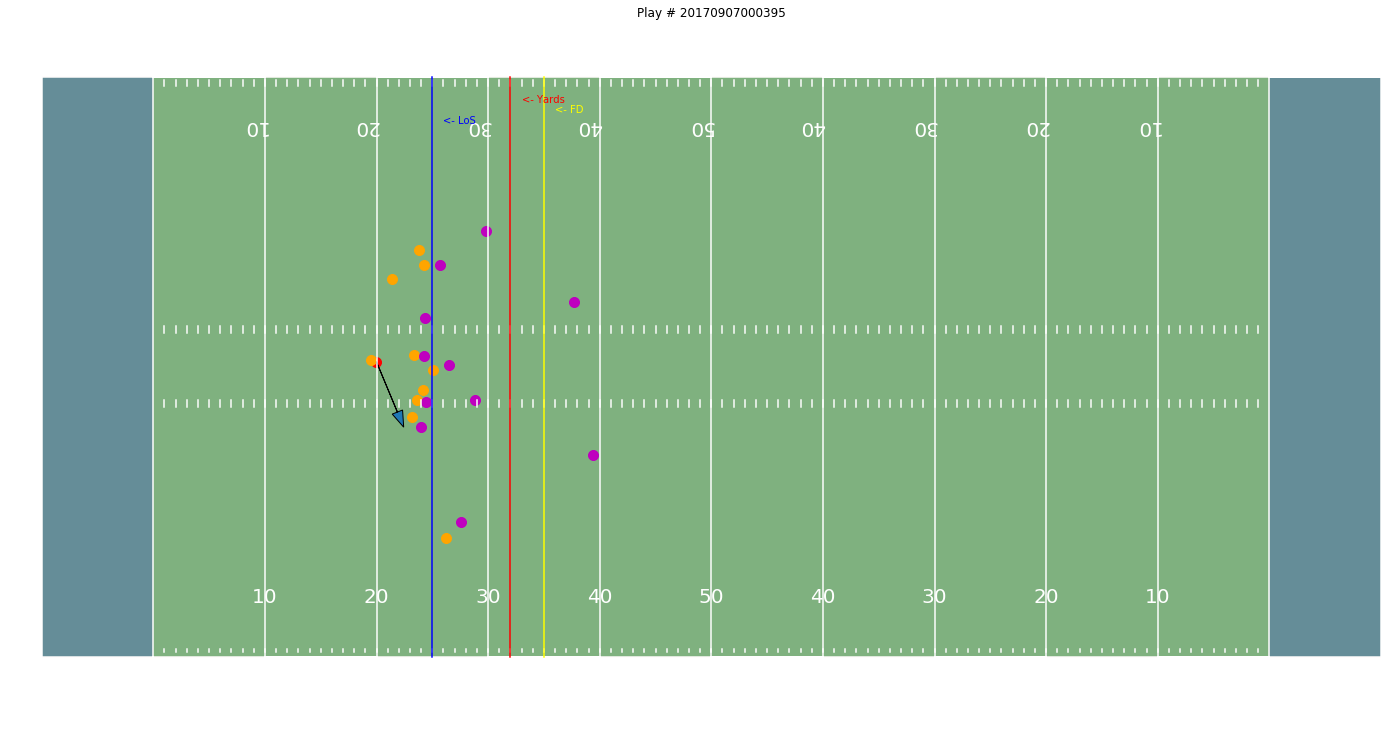

167.5 -> 172.5, playid sample = 20170907004314


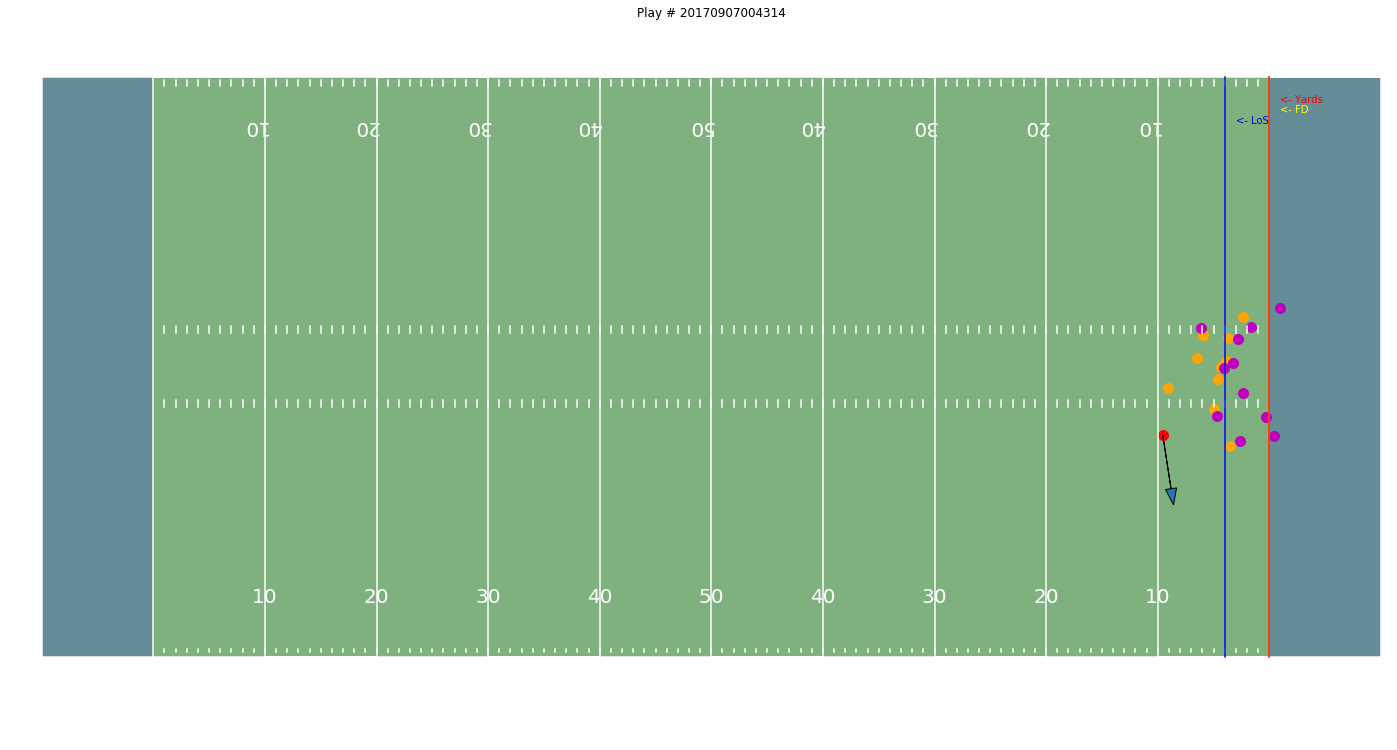

177.5 -> 182.5, playid sample = 20170907001296


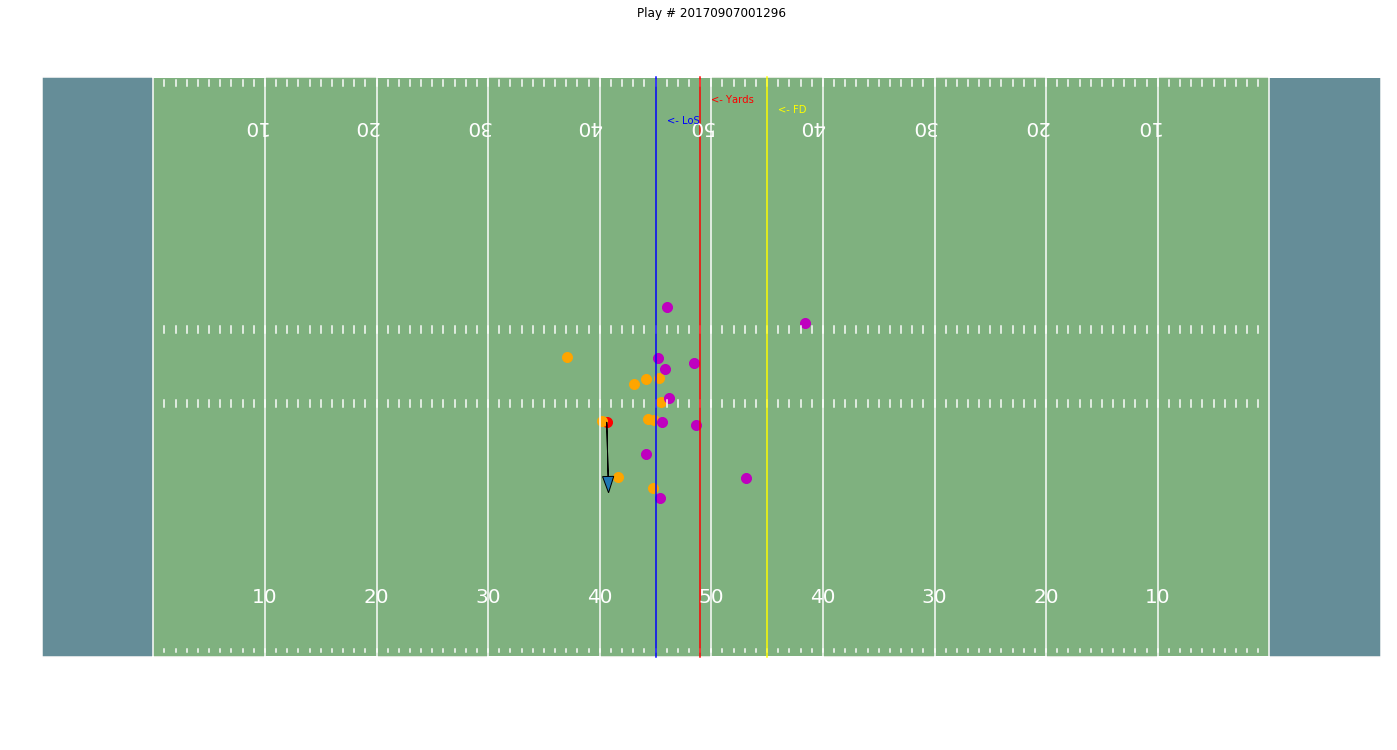

In [22]:
for i in range(-5, 185, 10):
    lower = i +2.5
    upper = lower+5
    playid = rusher_df.query('Dir_Std_Centered >= @lower and Dir_Std_Centered < @upper')['PlayId'].values[0]
    print("{} -> {}, playid sample = {}".format(lower, upper, playid))
    display_play(playid)
    plt.show()

# Defensive Scheme
Comparing the 3-4 defense with 4-3 and so on

In [23]:
rusher_df['DL_LB'] = rusher_df['DefensePersonnel'].str[:10].str.replace(' DL, ','-').str.replace(' LB','')
rusher_df['RB_TE_WR'] = rusher_df['OffensePersonnel'].str[-16:].str.replace(' RB, ','-').str.replace(' TE, ','-').str.replace(' WR','')

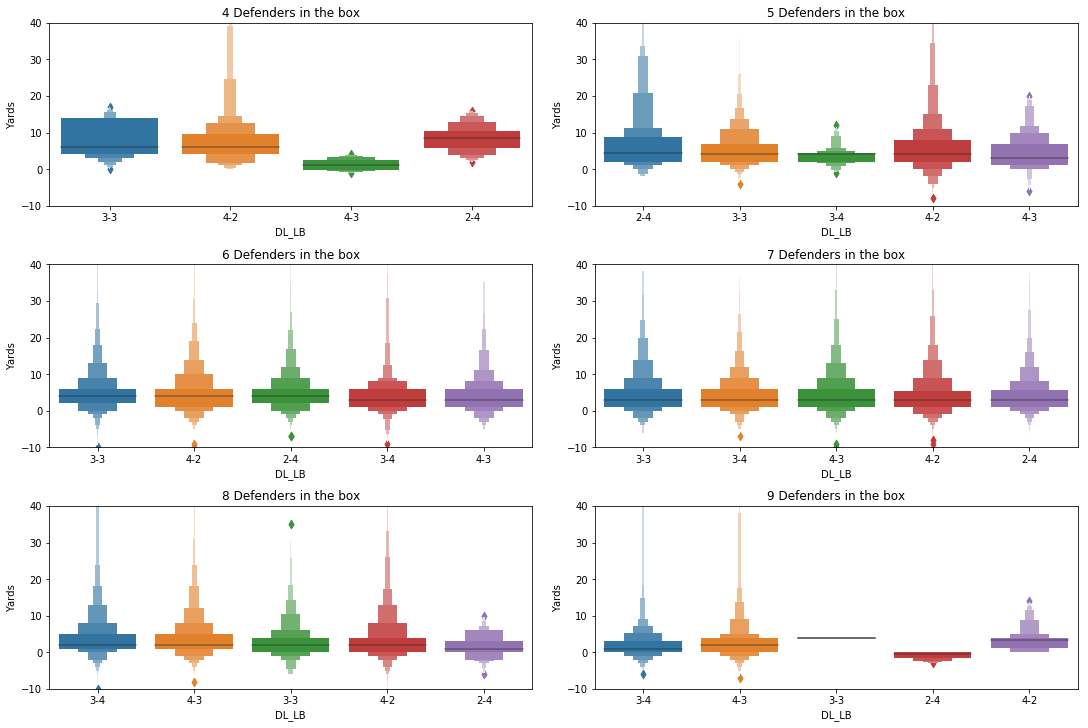

In [24]:
fig, axes = plt.subplots(3, 2, constrained_layout=True, figsize=(15 , 10))
#fig.tight_layout()
ax_idx = 0
ax_idx2 = 0
for in_box in range(4, 10):
    top_5_dl_lb_combos = rusher_df.groupby('DL_LB').count()['PlayId'].sort_values().tail(5).index.tolist()
    
    this_ax = axes[ax_idx2][ax_idx]
    df = rusher_df[rusher_df['DL_LB'].isin(top_5_dl_lb_combos)] \
        .query('DefendersInTheBox == @in_box')[['DL_LB','Yards']]
    
    sns.boxenplot(x="DL_LB", y="Yards", 
                data=df,
                ax=this_ax)
#     sns.distplot(df['Yards'],
#                 ax=this_ax,
#                 color=color_pal[ax_idx2])
    this_ax.set_title('{} Defenders in the box'.format(in_box))
    this_ax.set_ylim(-10, 40)
    ax_idx += 1
    if ax_idx == 2:
        ax_idx = 0
        ax_idx2 += 1
plt.show()




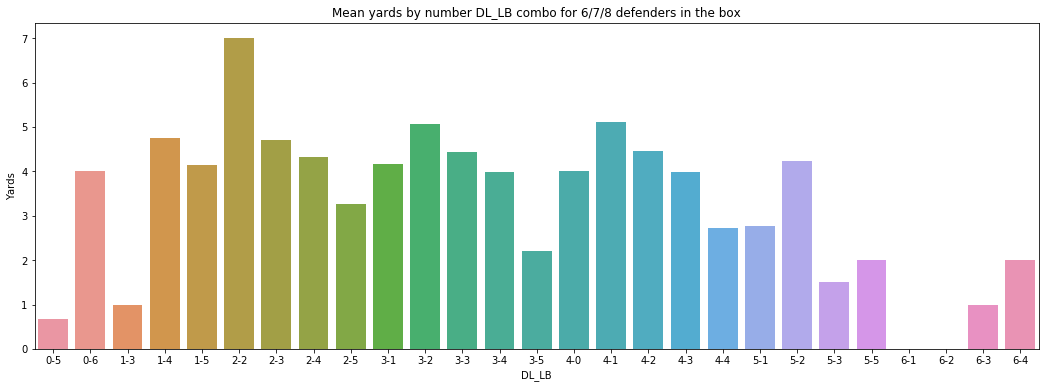

In [25]:
plt.figure(figsize=(18, 6))
df = rusher_df.query('DefendersInTheBox > 5 and DefendersInTheBox < 9')[['DL_LB','Yards']].groupby('DL_LB').mean().reset_index()
sns.barplot(x='DL_LB', y='Yards',data=df)
plt.title("Mean yards by number DL_LB combo for 6/7/8 defenders in the box")
plt.show()

In [26]:
dl_lb = rusher_df.query('DefendersInTheBox > 5 and DefendersInTheBox < 9') \
    [['DL_LB','Yards']].groupby('DL_LB').agg(['size', 'mean']) \
    .reset_index().sort_values(by=[('Yards', 'size')], ascending=False)
dl_lb

DL_LB Yards          
          size      mean
16   4-2  6083  4.464902
17   4-3  5917  3.981071
12   3-4  3453  3.984361
7    2-4  2495  4.327455
11   3-3  2100  4.427619
6    2-3   437  4.704805
15   4-1   347  5.118156
20   5-2   151  4.231788
10   3-2   136  5.058824
18   4-4    86  2.720930
19   5-1    39  2.769231
3    1-4    38  4.763158
4    1-5    28  4.142857
8    2-5    22  3.272727
13   3-5    15  2.200000
21   5-3    14  1.500000
9    3-1     6  4.166667
0    0-5     3  0.666667
5    2-2     3  7.000000
1    0-6     2  4.000000
14   4-0     1  4.000000
2    1-3     1  1.000000
22   5-5     1  2.000000
23   6-1     1  0.000000
24   6-2     1  0.000000
25   6-3     1  1.000000
26   6-4     1  2.000000

For the standard values there is not much difference. This could be useful but probably after some other obvious magic features

# Standard Plays
It's obvious to find difference in the yards for irregular plays. But we need to look at any way to separate the most common plays. Like the 6,7,8 defenders in the box.

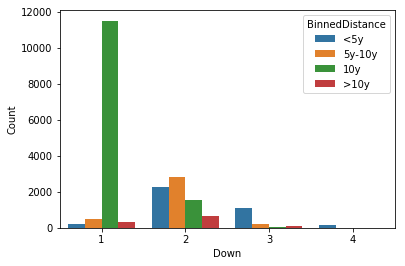

In [27]:
rusher_df['BinnedDistance'] = pd.cut(rusher_df['Distance'], bins=[0, 4.5, 9.5, 10.5, 100], labels=['<5y','5y-10y','10y', '>10y'])
dl_lb = rusher_df.query('DefendersInTheBox > 5 and DefendersInTheBox < 9') \
    [['Down','BinnedDistance']].groupby(['Down', 'BinnedDistance']).size().reset_index().rename(columns={0:'Count'})
sns.barplot(x="Down",y="Count",hue="BinnedDistance", data=dl_lb)

As we can see the most common are the 1st downs at 10 yards away. We should make our main model on the 1st and 2nd down for a 10 yard distance. And more common things like the actual RB. Then do some work looking at smaller values

## 1st and 10

In [28]:
rusher_first_ten = rusher_df.query('Down == 1 and Distance == 10')
rusher_first_ten[['Position', 'Yards']].groupby('Position').agg(['size', 'mean']) \
    .reset_index().sort_values(by=[('Yards', 'size')], ascending=False)

Position  Yards          
             size      mean
4       RB  11231  4.394622
6       WR    378  6.476190
2       HB    325  4.815385
1       FB     56  3.464286
3       QB     30  3.300000
5       TE     11  7.454545
0       CB      3  9.333333

In [29]:
rusher_df[['Position', 'Yards']].groupby('Position').agg(['size', 'mean']) \
    .reset_index().sort_values(by=[('Yards', 'size')], ascending=False)

Position  Yards          
             size      mean
6       RB  21628  4.172739
8       WR    638  5.921630
4       HB    616  4.318182
3       FB    169  3.041420
5       QB     77  2.363636
7       TE     31  4.258065
0       CB      9  9.777778
2       DT      2  1.000000
1       DE      1  0.000000

In [453]:
rusher_first_ten_rb = rusher_df.query("Down == 1 and Distance == 10 and Position == 'RB'")


-2.5 -> 2.5, playid sample = 20170917002967


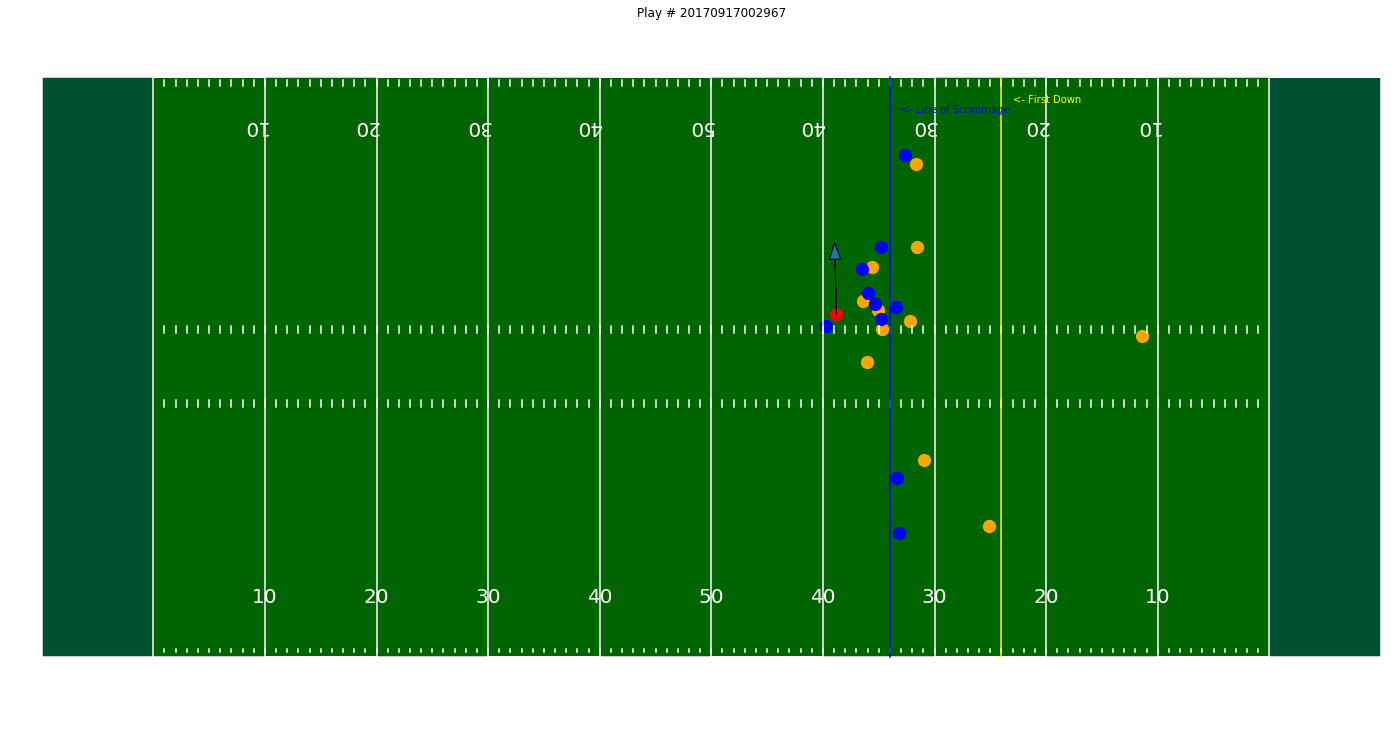

7.5 -> 12.5, playid sample = 20170907004465


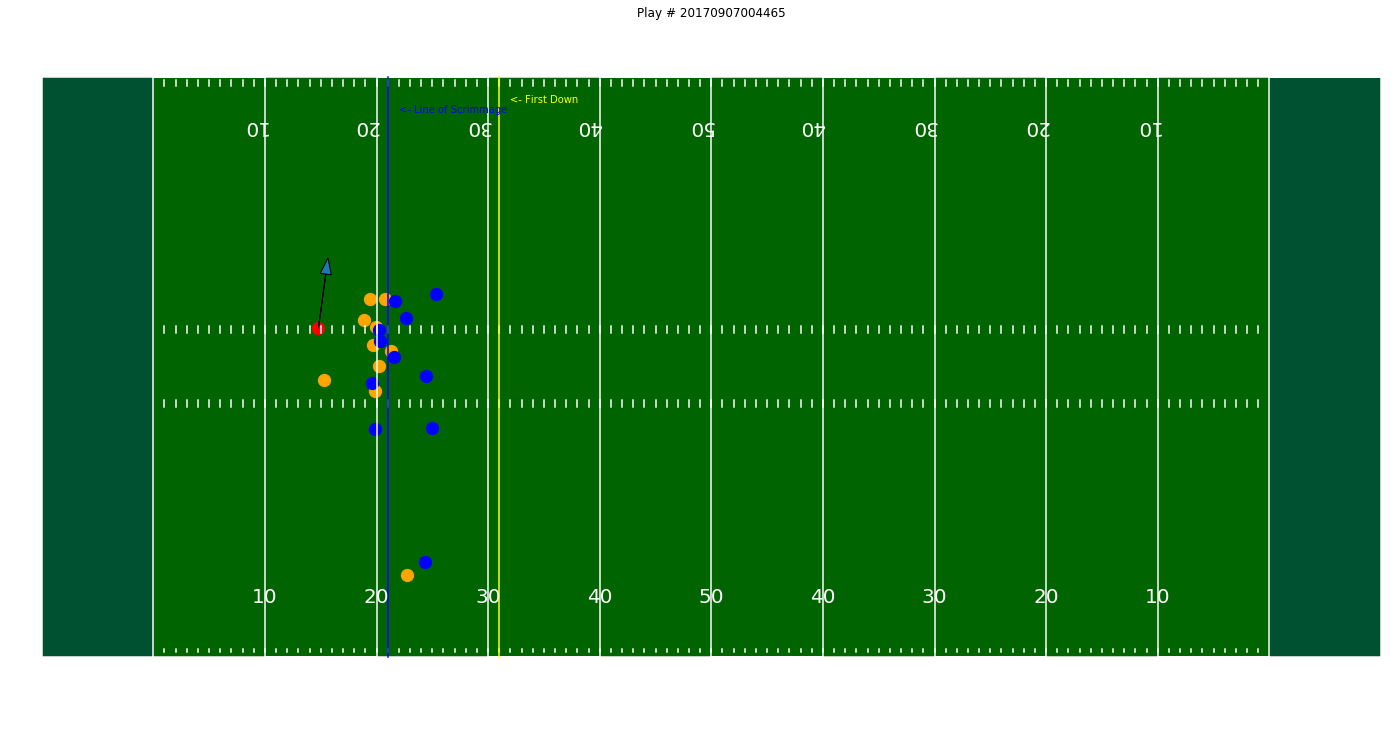

17.5 -> 22.5, playid sample = 20170907001509


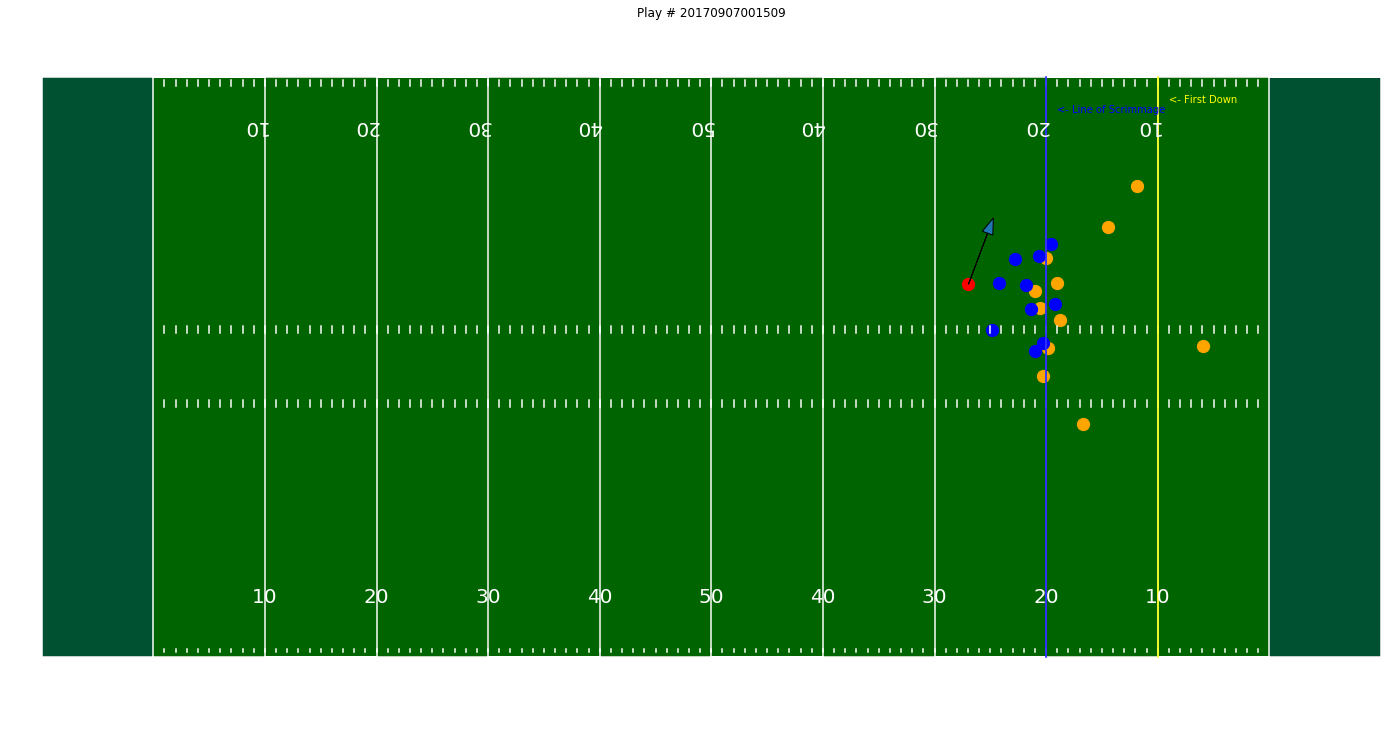

27.5 -> 32.5, playid sample = 20170910010164


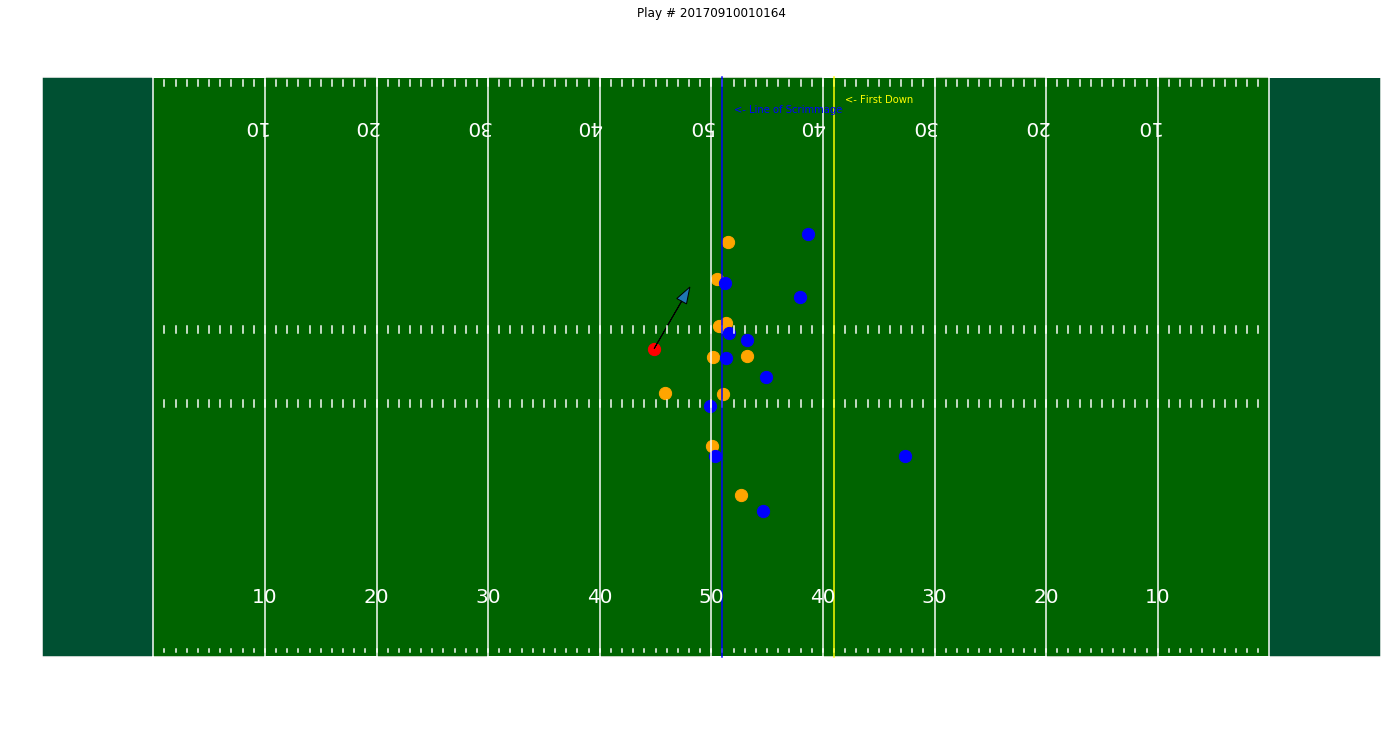

37.5 -> 42.5, playid sample = 20170907000189


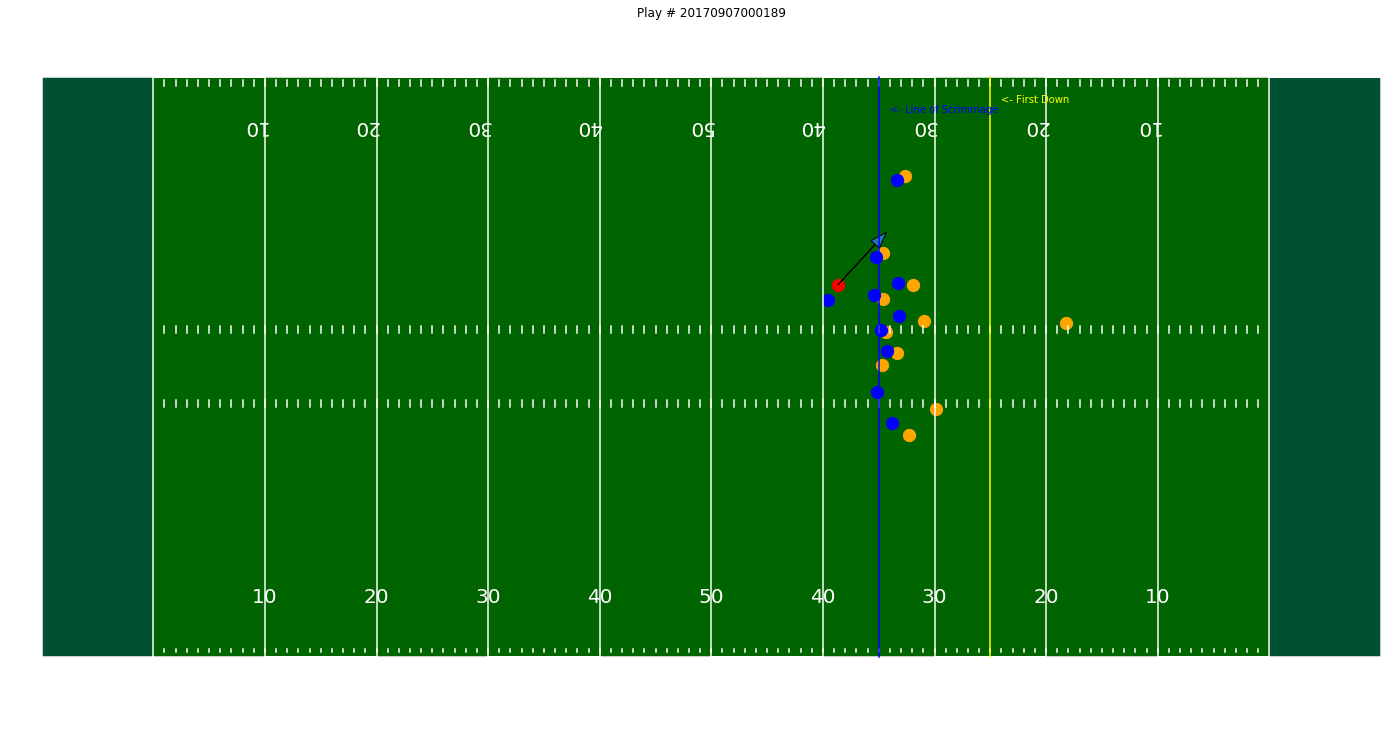

47.5 -> 52.5, playid sample = 20170910020344


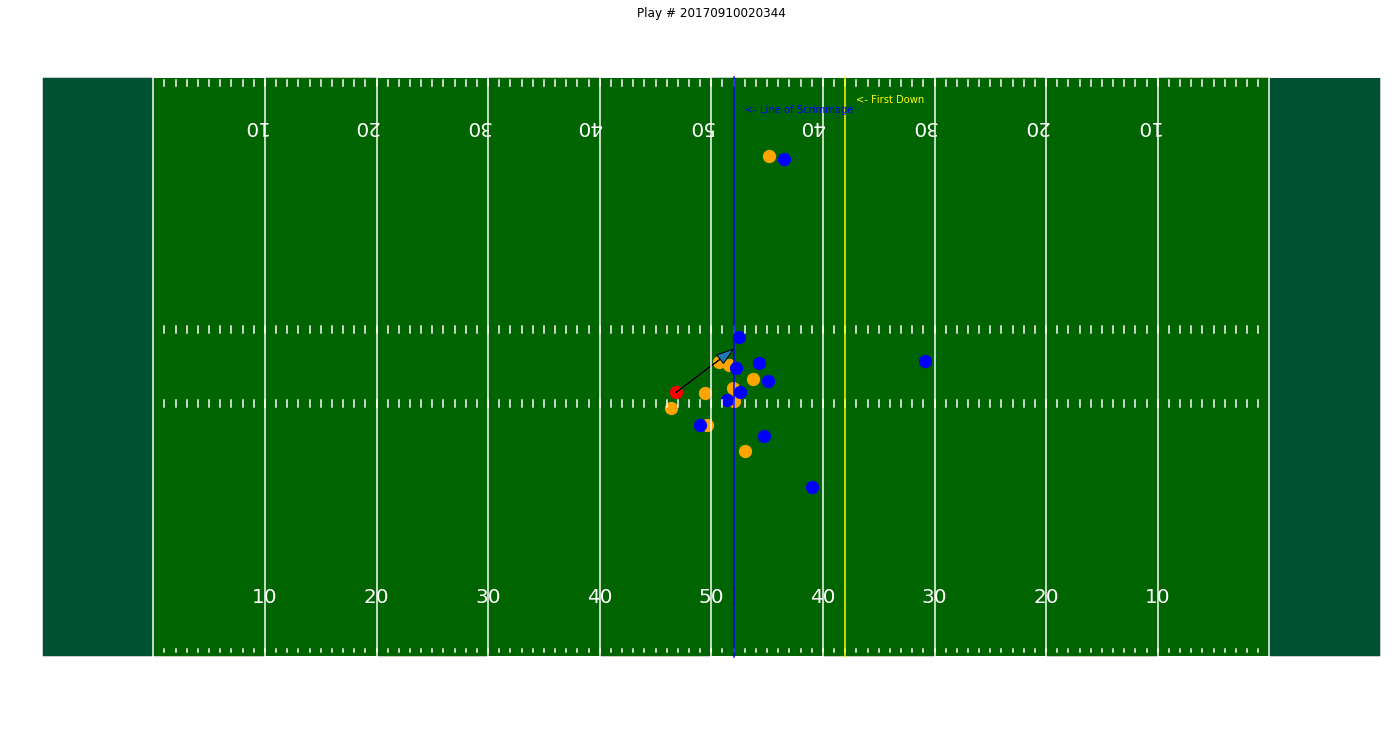

57.5 -> 62.5, playid sample = 20170910030626


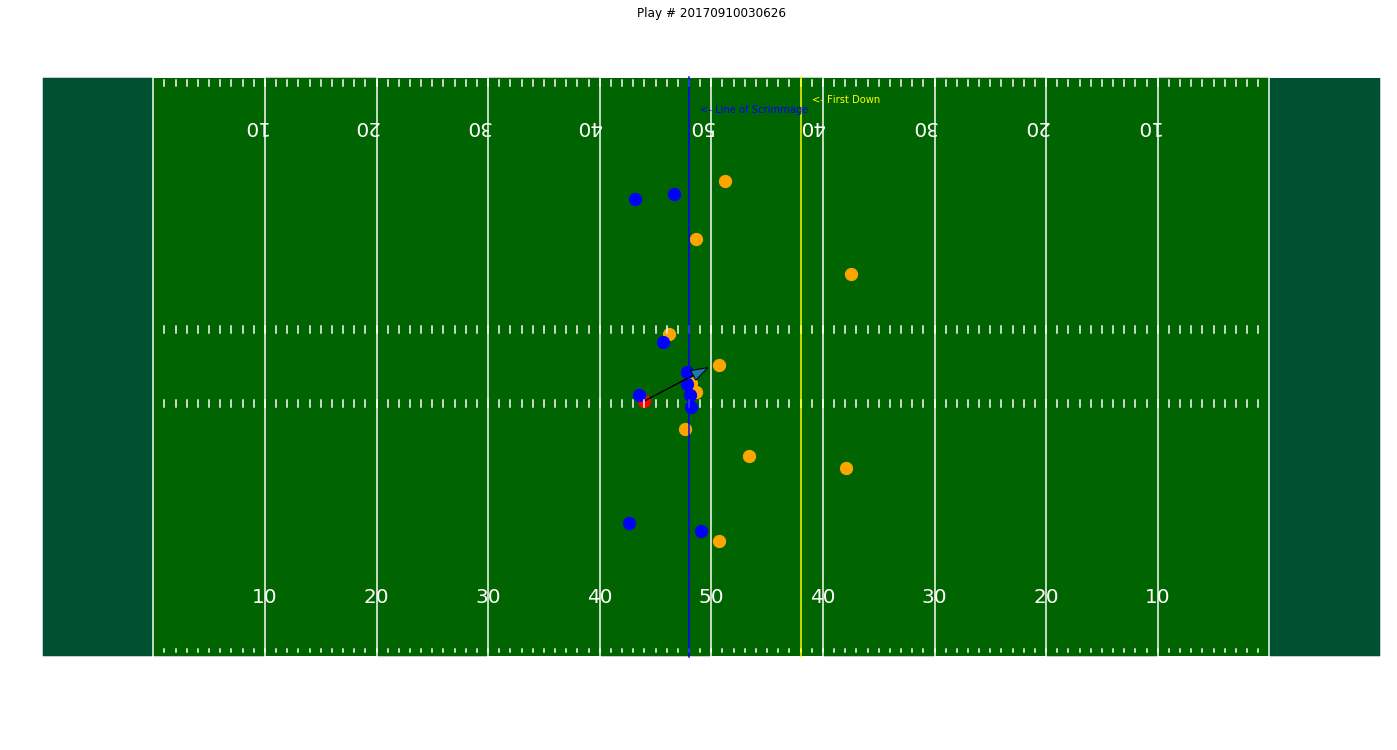

67.5 -> 72.5, playid sample = 20170910004196


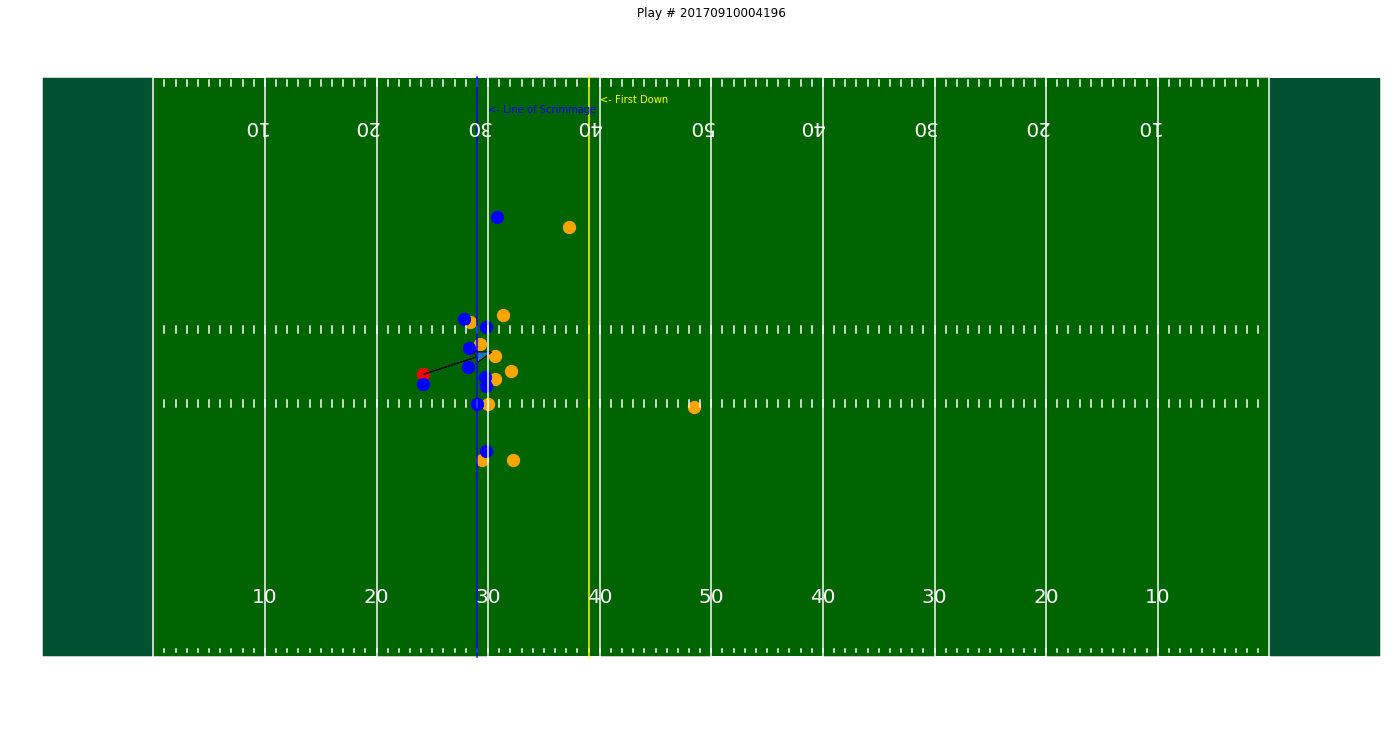

77.5 -> 82.5, playid sample = 20170910051555


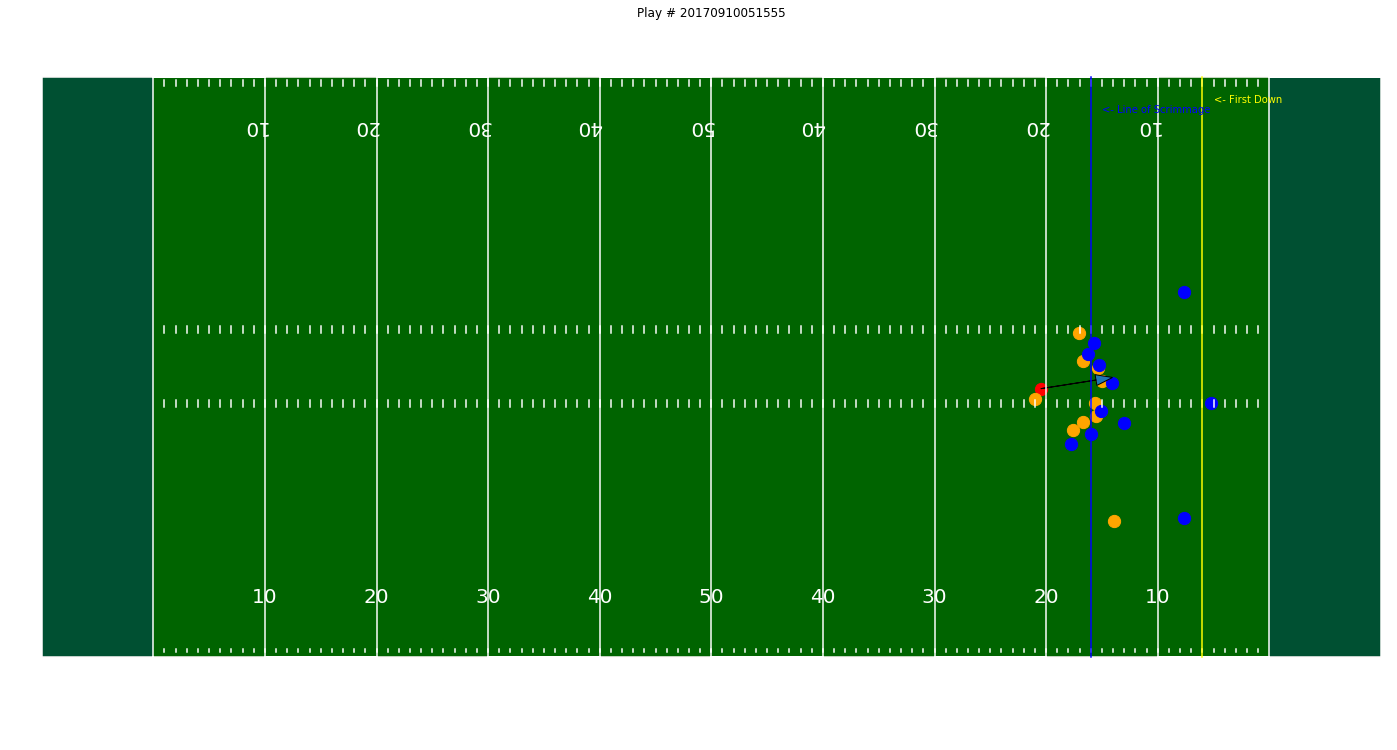

87.5 -> 92.5, playid sample = 20170910011478


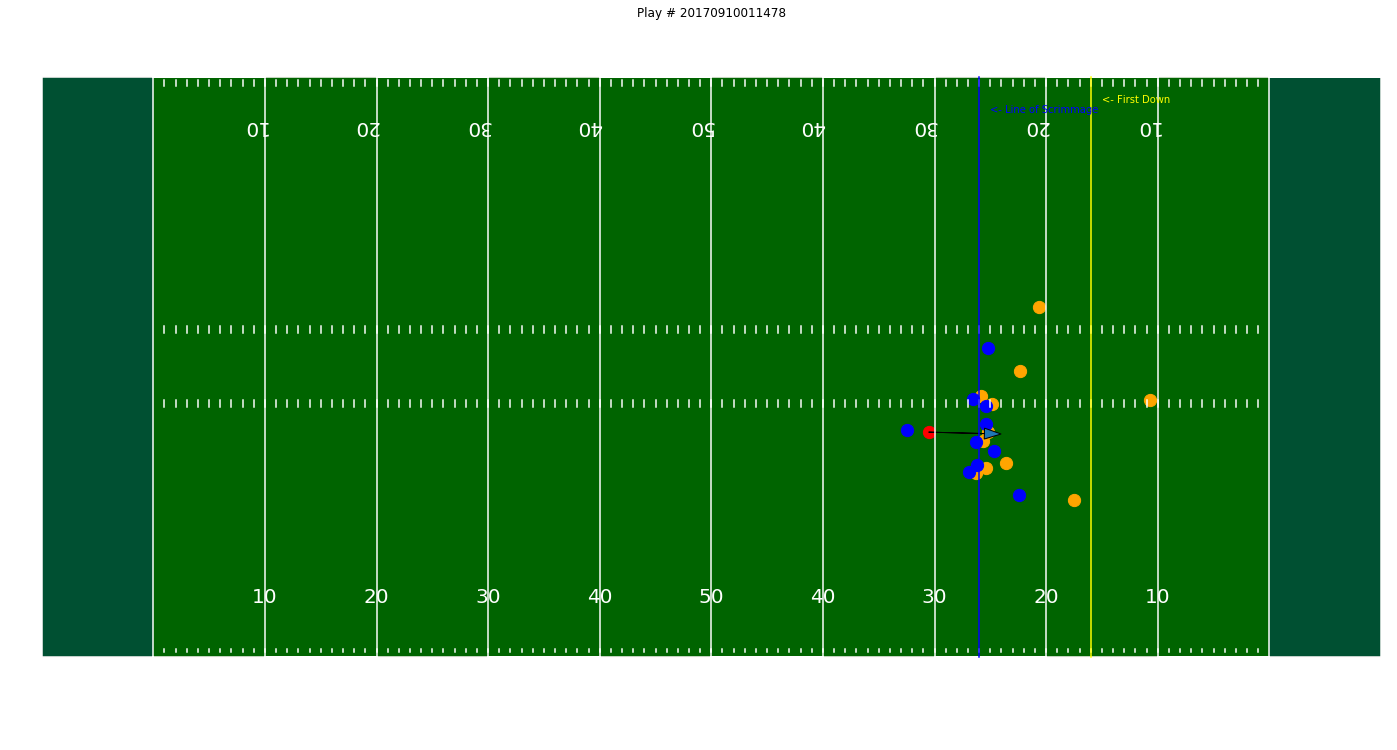

97.5 -> 102.5, playid sample = 20170907004025


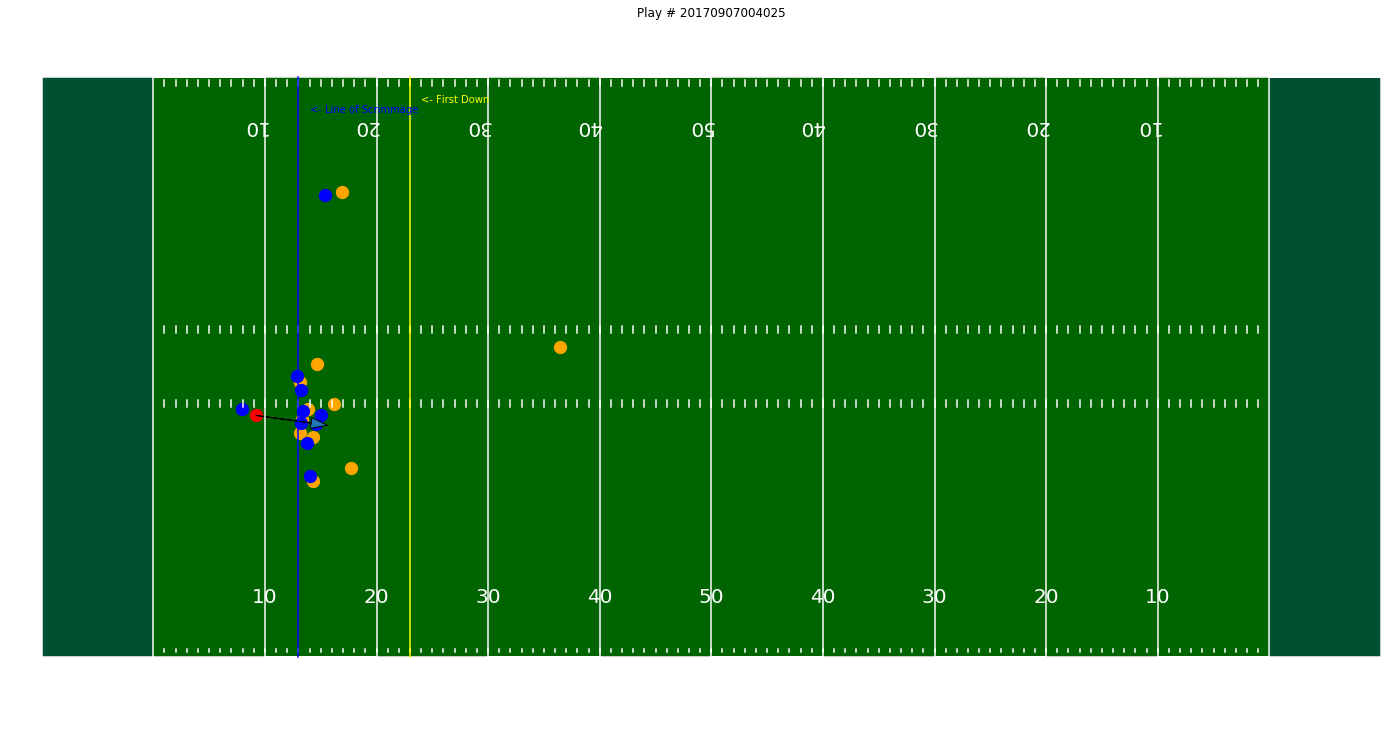

107.5 -> 112.5, playid sample = 20170910051312


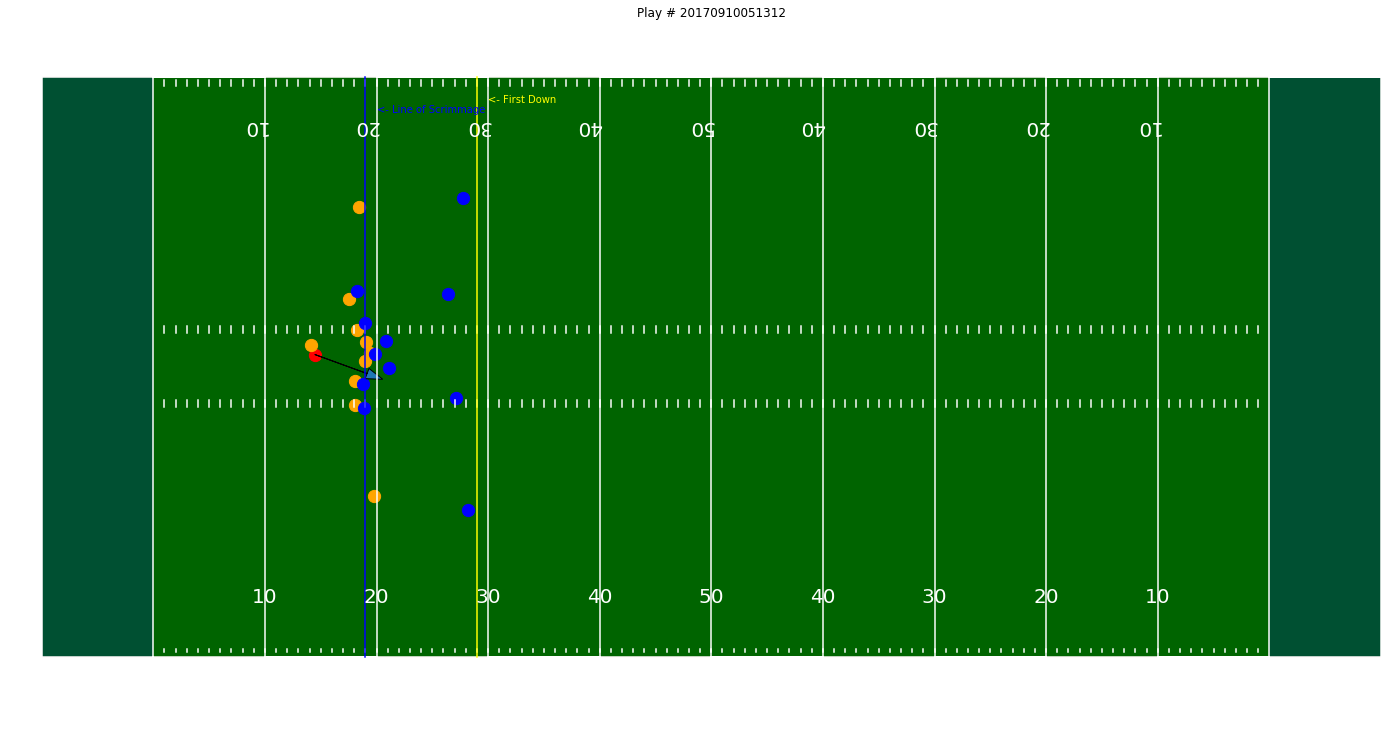

117.5 -> 122.5, playid sample = 20170910042481


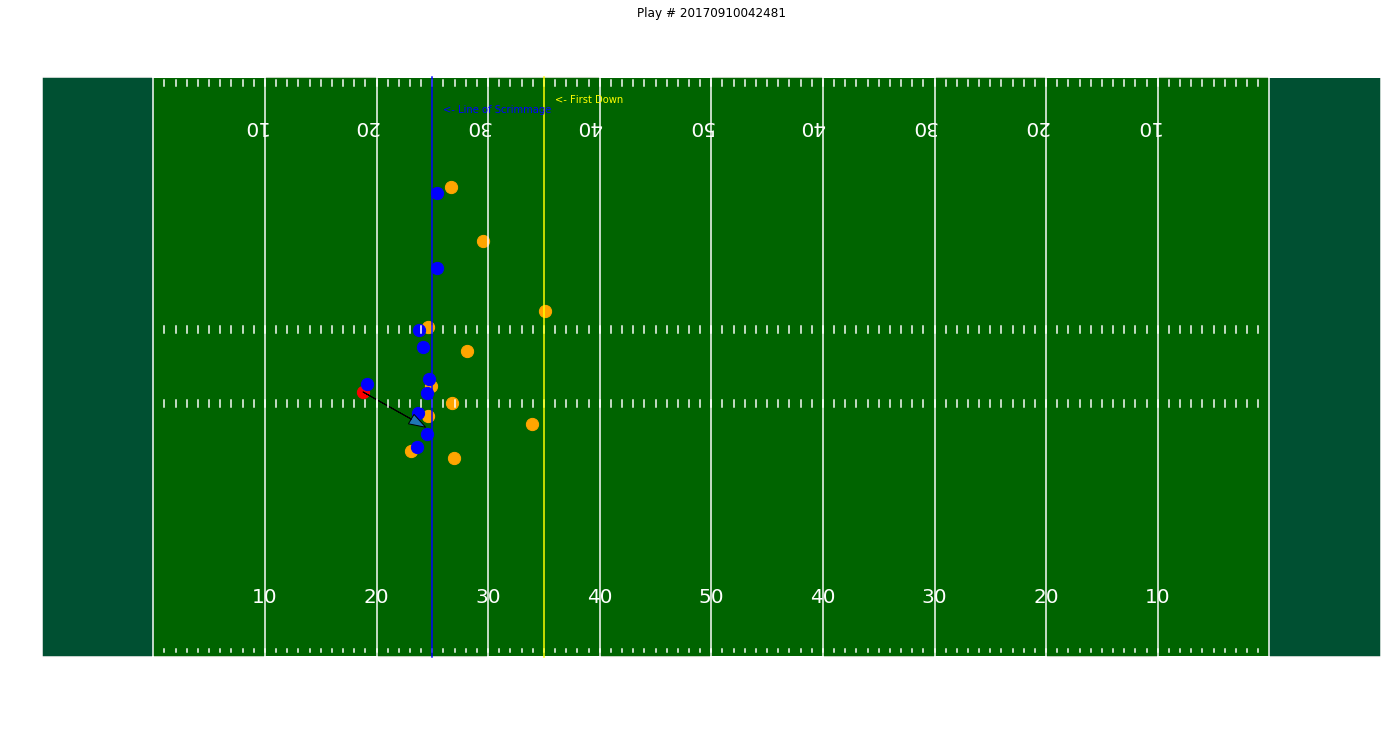

127.5 -> 132.5, playid sample = 20170907000139


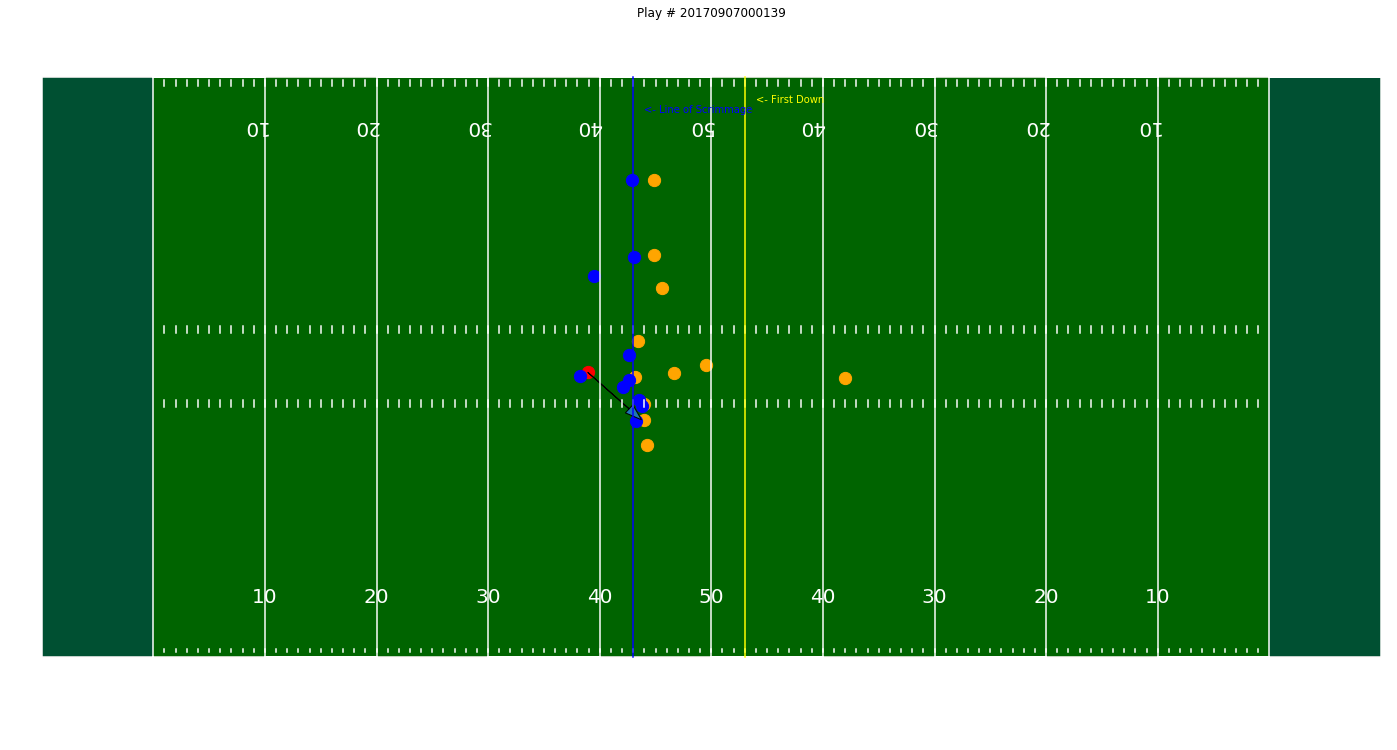

137.5 -> 142.5, playid sample = 20170907000801


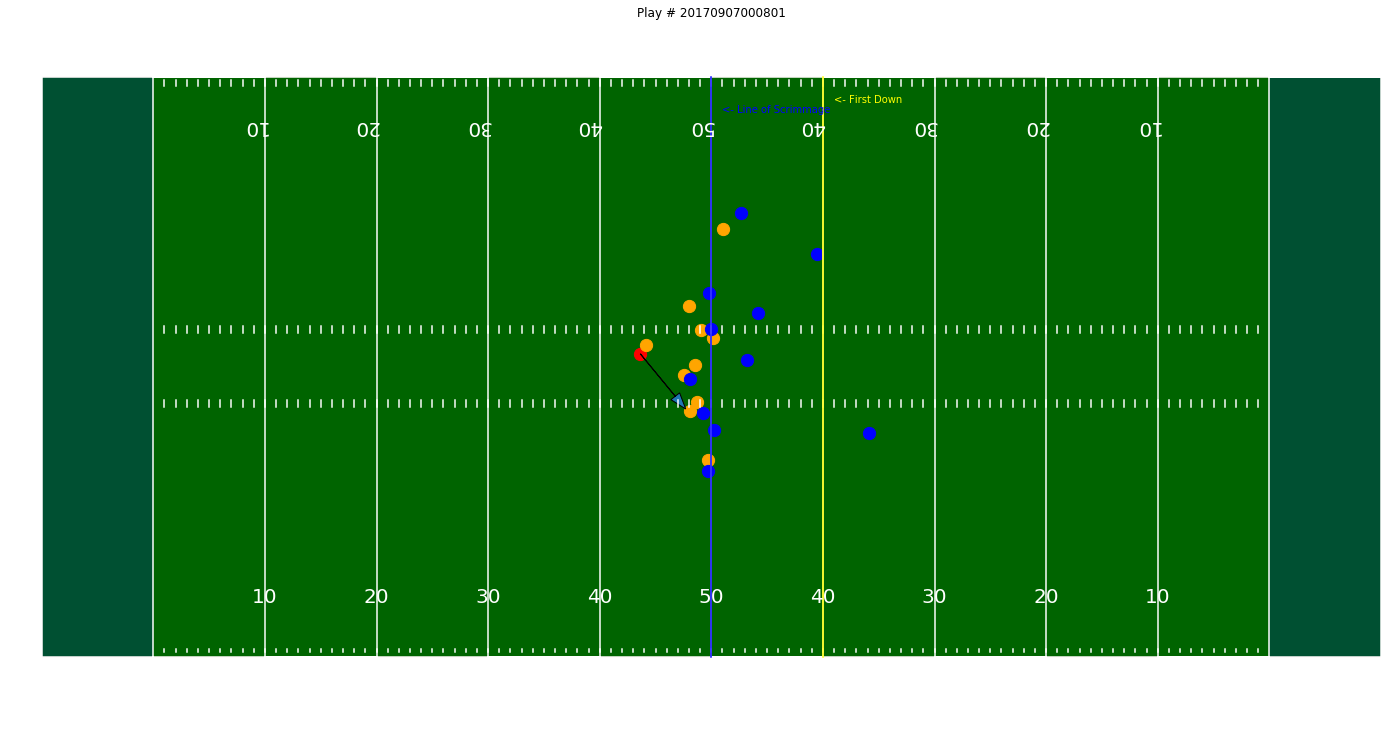

147.5 -> 152.5, playid sample = 20170910001543


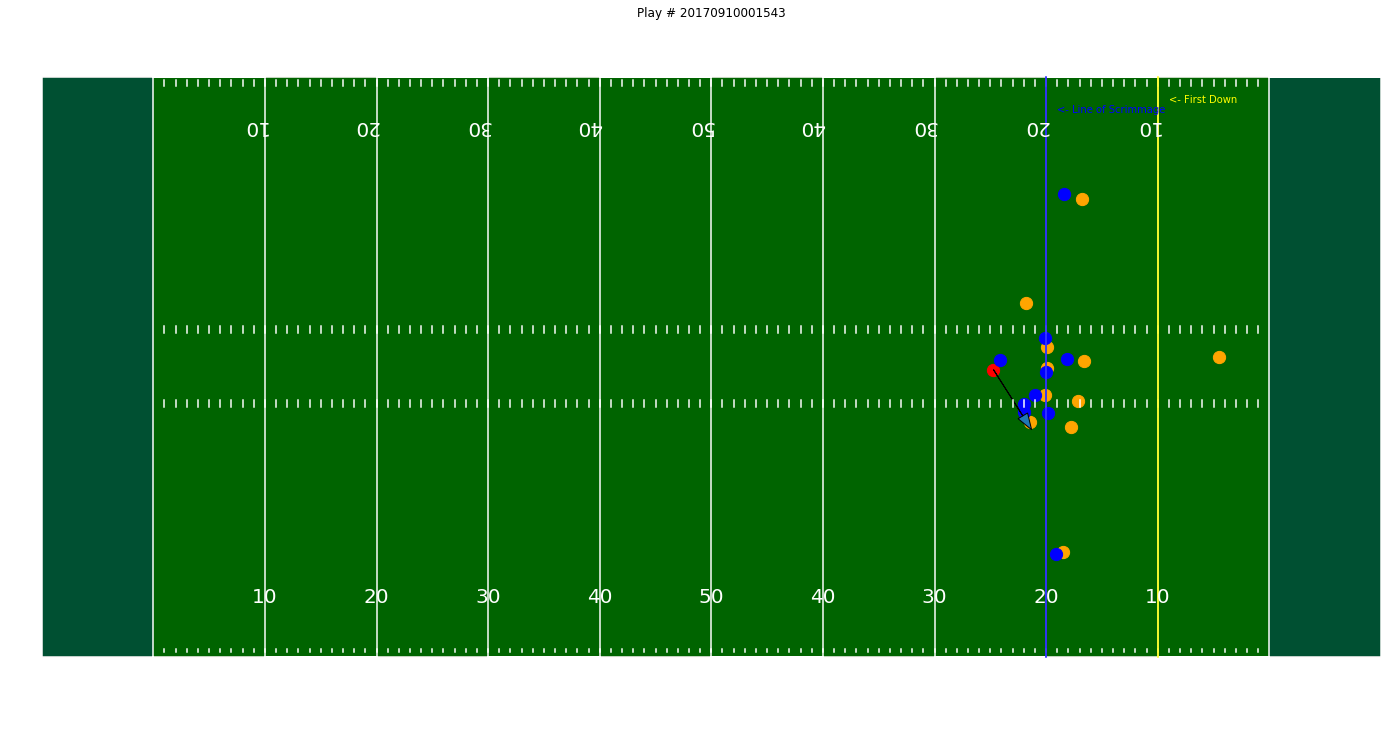

157.5 -> 162.5, playid sample = 20170907000395


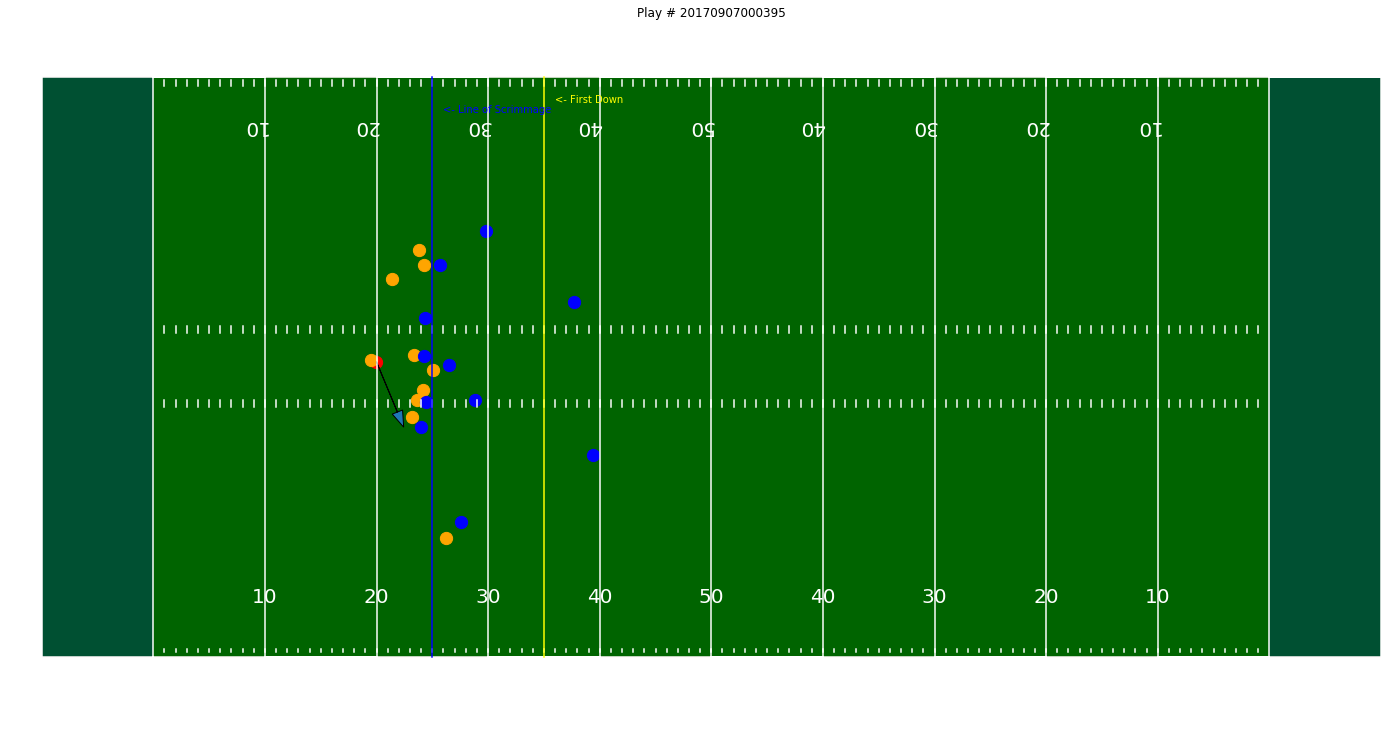

167.5 -> 172.5, playid sample = 20170910053265


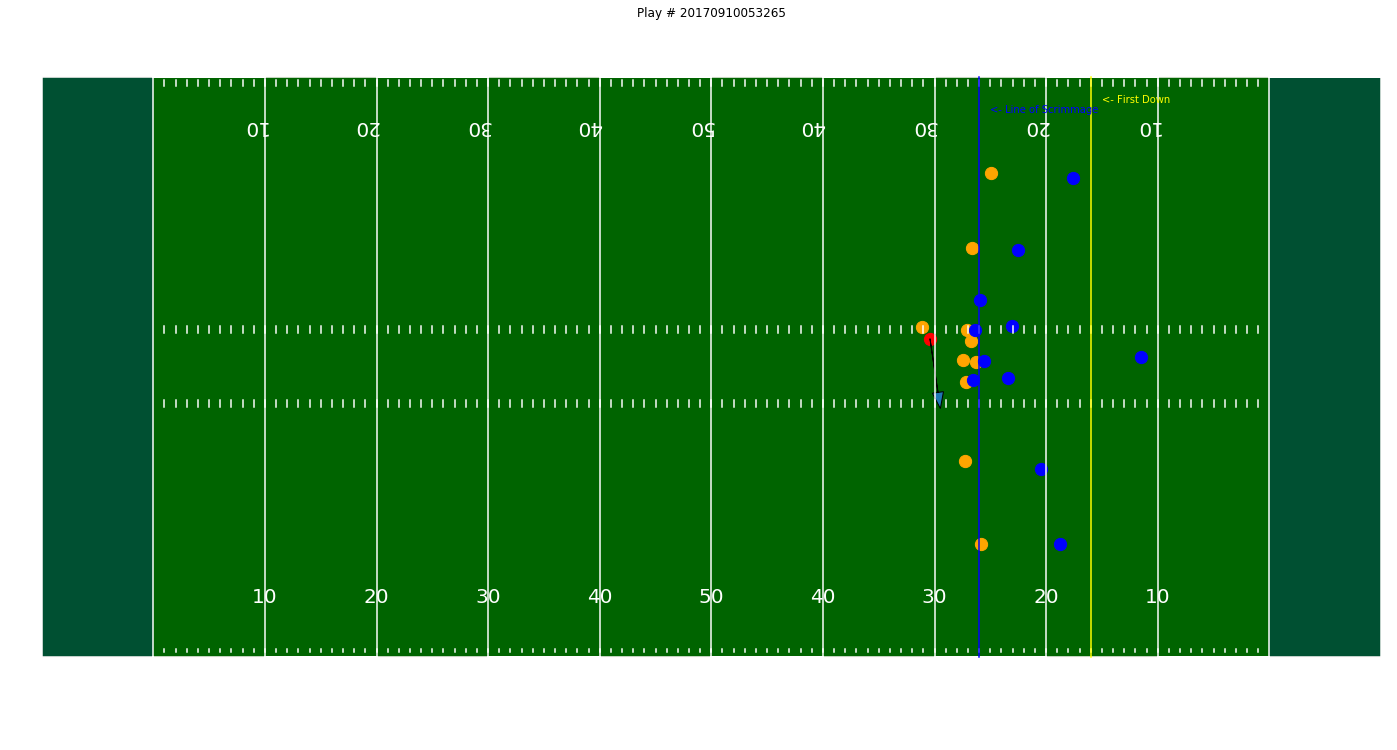

177.5 -> 182.5, playid sample = 20171015033407


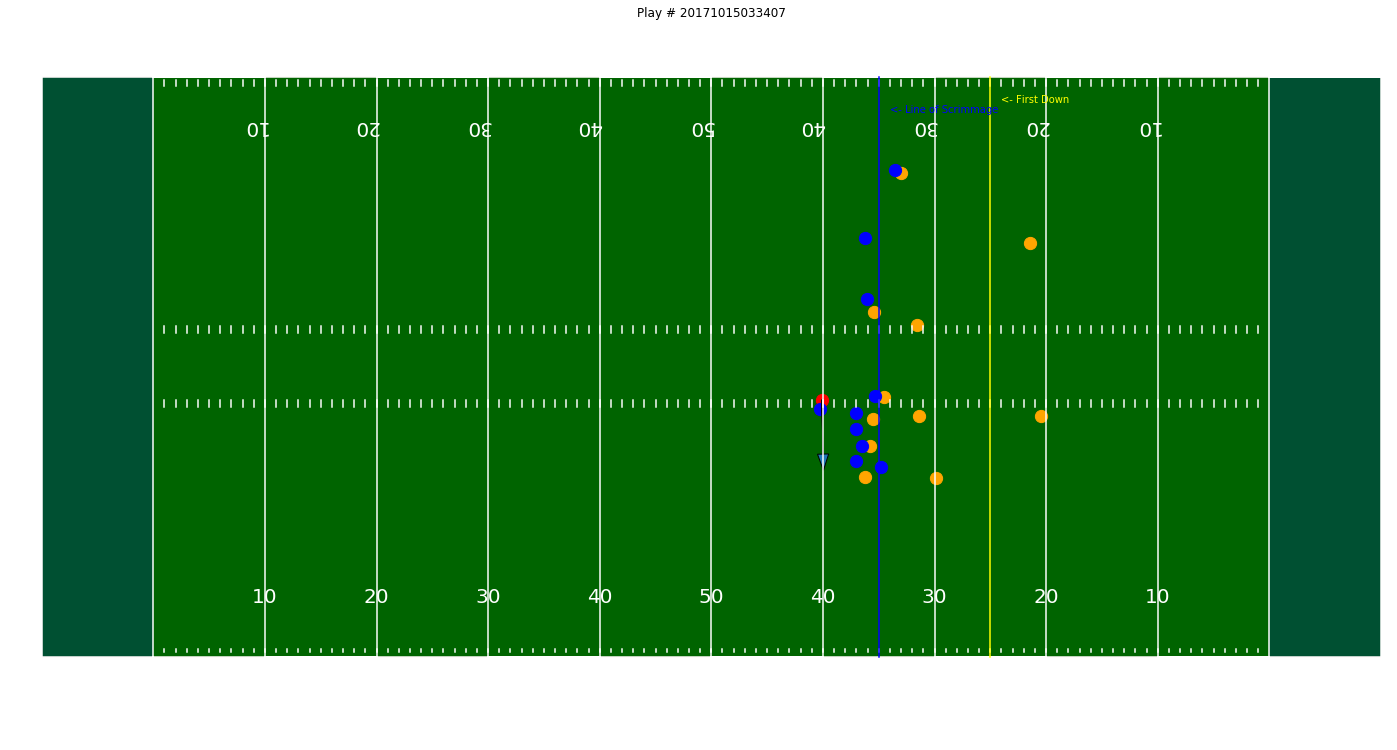

In [347]:
for i in range(-5, 185, 10):
    lower = i +2.5
    upper = lower+5
    playid = rusher_first_ten_rb.query('Dir_Std_Centered >= @lower and Dir_Std_Centered < @upper')['PlayId'].values[0]
    print("{} -> {}, playid sample = {}".format(lower, upper, playid))
    display_play(playid)
    plt.show()

Based on the standard plays: 10 yards out, first down, given to RB. Let's start with some basic possibilities
1. Player goes wide on the side they started from. e.g. 20170907001509
2. Player goes in center or off center. The amount off center can be decided by the side they went from
3. Sweep across
4. Going backwards but that doesn't happen enough

In [454]:
r_wide_plays = rusher_first_ten_rb.query("(Dir_Std_Centered < 40 and Dir_Std_Centered > -30 and Y_Std > 28) " \
                          + " or (Dir_Std_Centered > 130 and Dir_Std_Centered < 210 and Y_Std < 24.5)")
r_center_plays = rusher_first_ten_rb.query("not ((Dir_Std_Centered < 40 and Dir_Std_Centered > -30 and Y_Std > 28) " \
                          + " or (Dir_Std_Centered > 130 and Dir_Std_Centered < 210 and Y_Std < 24.5))")
r_wide_plays.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,X_Std,Y_Std,YardLine_Std,Orientation_Std,Dir_Std,HasBall,IsRusher,Dir_Std_Centered,DL_LB,BinnedDistance,RB_TE_WR
458,2017090700,20170907001509,home,83.04,34.24,5.34,2.61,0.57,329.15,20.06,2539663,Mike Gillislee,35,2017,20,2,09:17:00,NE,1,10,KC,10,7,2539663,I_FORM,"2 RB, 2 TE, 1 WR",7.0,"3 DL, 4 LB, 4 DB",right,2017-09-08T01:38:37.000Z,2017-09-08T01:38:36.000Z,9,5-11,210,11/01/1990,Florida,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,83.04,34.24,20,329.15,20.06,True,True,20.06,3-4,10y,2-2-1
538,2017090700,20170907001664,away,91.50,30.70,4.64,3.01,0.48,230.16,347.43,2557917,Kareem Hunt,27,2017,23,2,07:22:00,KC,1,10,KC,17,7,2557917,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",left,2017-09-08T01:46:09.000Z,2017-09-08T01:46:07.000Z,3,5-11,216,08/06/1995,Toledo,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,28.50,22.60,77,50.16,167.43,True,True,167.43,4-3,10y,2-1-2
1044,2017090700,20170907004465,away,24.80,30.22,4.99,3.75,0.45,350.12,7.50,2557917,Kareem Hunt,27,2017,21,4,04:15:00,KC,1,10,KC,27,35,2557917,SHOTGUN,"1 RB, 3 TE, 1 WR",9.0,"5 DL, 2 LB, 4 DB",right,2017-09-08T04:03:55.000Z,2017-09-08T04:03:54.000Z,58,5-11,216,08/06/1995,Toledo,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,24.80,30.22,21,350.12,7.50,True,True,7.50,5-2,10y,1-3-1
1310,2017091000,20170910000882,home,92.74,32.75,4.74,2.05,0.51,202.75,322.48,79607,LeSean McCoy,25,2017,23,1,01:57:00,BUF,1,10,BUF,0,0,79607,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",left,2017-09-10T17:33:33.000Z,2017-09-10T17:33:31.000Z,-1,5-11,210,07/12/1988,Pittsburgh,RB,BUF,NYJ,1,New Era Field,Orchard Park NY,Outdoors,A-Turf Titan,Sun & clouds,65.0,53.0,6,NNE,27.26,20.55,77,22.75,142.48,True,True,142.48,4-3,10y,2-1-2
1628,2017091000,20170910002477,away,26.25,22.45,1.37,2.78,0.11,14.05,136.58,234,Matt Forte,22,2017,21,3,10:41:00,NYJ,1,10,NYJ,7,6,234,SHOTGUN,"6 OL, 1 RB, 0 TE, 3 WR",7.0,"4 DL, 2 LB, 5 DB",right,2017-09-10T18:46:14.000Z,2017-09-10T18:46:13.000Z,0,6-2,218,12/10/1985,Tulane,RB,BUF,NYJ,1,New Era Field,Orchard Park NY,Outdoors,A-Turf Titan,Sun & clouds,65.0,53.0,6,NNE,26.25,22.45,21,14.05,136.58,True,True,136.58,4-2,10y,1-0-3


In [499]:
from sklearn.neighbors import NearestNeighbors
# This isnt useful at the moment but I imagine it will be in the future
def get_knn_defenders(defenders_df, num):
    knn = NearestNeighbors(n_neighbors=num)
    points = defenders_df[['X_Std', 'Y_Std']].as_matrix()
    knn.fit(points)
    indices = knn.kneighbors(points, return_distance=False)
    
    in_box = defenders_df.iloc[indices[0].tolist()]
    return in_box
   
playid = r_center_plays['PlayId'].sample(1).tolist()[0]
d_df = train_df.query("HasBall == False and PlayId == @playid")

num_in_the_box = int(d_df['DefendersInTheBox'].tolist()[0])
defenders_in_the_box = get_defenders_in_box(d_df, num_in_the_box)


In [502]:
from sklearn.neighbors import NearestNeighbors
# This isnt useful at the moment but I imagine it will be in the future
def get_defenders_in_box(defenders_df, num, ):
    knn = NearestNeighbors(n_neighbors=num)
    points = defenders_df[['X_Std', 'Y_Std']].as_matrix()
    knn.fit(points)
    indices = knn.kneighbors(rusher_df[['X_Std','Y_Std']].as_matrix(), return_distance=False)
    
    in_box = defenders_df.iloc[indices[0].tolist()]
    return in_box
   
playid = 20181223140902 #r_center_plays['PlayId'].sample(1).tolist()[0]
d_df = train_df.query("HasBall == False and PlayId == @playid")
rusher_df = train_df.query("IsRusher == True and PlayId == @playid")
num_in_the_box = int(d_df['DefendersInTheBox'].tolist()[0])
defenders_in_the_box = get_defenders_in_box(rusher_df, d_df, num_in_the_box)
defenders_in_the_box

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,X_Std,Y_Std,YardLine_Std,Orientation_Std,Dir_Std,HasBall,IsRusher
491966,2018122314,20181223140902,away,27.17,30.66,4.58,0.26,0.46,138.25,176.53,2495493,Justin Houston,50,2018,18,1,03:21:00,SEA,1,10,KC,7,3,2553439,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 3 LB, 5 DB",left,2018-12-24T01:52:46.000Z,2018-12-24T01:52:45.000Z,3,6-3,270,01/21/1989,Georgia,DE,SEA,KC,16,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,43.0,82.0,8,SSE,92.83,22.64,82,318.25,356.53,False,False
491965,2018122314,20181223140902,away,27.06,28.72,2.81,0.51,0.28,96.73,173.28,2495116,Allen Bailey,97,2018,18,1,03:21:00,SEA,1,10,KC,7,3,2553439,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 3 LB, 5 DB",left,2018-12-24T01:52:46.000Z,2018-12-24T01:52:45.000Z,3,6-3,288,03/25/1989,Miami,DE,SEA,KC,16,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,43.0,82.0,8,SSE,92.94,24.58,82,276.73,353.28,False,False
491971,2018122314,20181223140902,away,28.05,25.46,1.80,1.67,0.16,32.04,159.36,2556369,Chris Jones,95,2018,18,1,03:21:00,SEA,1,10,KC,7,3,2553439,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 3 LB, 5 DB",left,2018-12-24T01:52:46.000Z,2018-12-24T01:52:45.000Z,3,6-6,308,07/03/1994,Mississippi State,DT,SEA,KC,16,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,43.0,82.0,8,SSE,91.95,27.84,82,212.04,339.36,False,False
491969,2018122314,20181223140902,away,29.18,34.53,4.42,1.95,0.44,163.45,141.78,2550257,Daniel Sorensen,49,2018,18,1,03:21:00,SEA,1,10,KC,7,3,2553439,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 3 LB, 5 DB",left,2018-12-24T01:52:46.000Z,2018-12-24T01:52:45.000Z,3,6-2,208,03/05/1990,Brigham Young,SS,SEA,KC,16,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,43.0,82.0,8,SSE,90.82,18.77,82,343.45,321.78,False,False
491967,2018122314,20181223140902,away,28.92,23.41,1.34,1.84,0.11,53.83,111.52,2543494,Dee Ford,55,2018,18,1,03:21:00,SEA,1,10,KC,7,3,2553439,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 3 LB, 5 DB",left,2018-12-24T01:52:46.000Z,2018-12-24T01:52:45.000Z,3,6-2,252,03/19/1991,Auburn,DE,SEA,KC,16,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,43.0,82.0,8,SSE,91.08,29.89,82,233.83,291.52,False,False
491972,2018122314,20181223140902,away,24.08,31.07,3.25,0.54,0.32,109.46,165.32,2560827,Dorian O'Daniel,44,2018,18,1,03:21:00,SEA,1,10,KC,7,3,2553439,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 3 LB, 5 DB",left,2018-12-24T01:52:46.000Z,2018-12-24T01:52:45.000Z,3,6-1,220,09/04/1994,Clemson,LB,SEA,KC,16,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,43.0,82.0,8,SSE,95.92,22.23,82,289.46,345.32,False,False
491968,2018122314,20181223140902,away,23.75,27.02,1.94,1.67,0.19,101.67,142.42,2543592,Anthony Hitchens,53,2018,18,1,03:21:00,SEA,1,10,KC,7,3,2553439,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 3 LB, 5 DB",left,2018-12-24T01:52:46.000Z,2018-12-24T01:52:45.000Z,3,6-0,235,06/10/1992,Iowa,MLB,SEA,KC,16,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,43.0,82.0,8,SSE,96.25,26.28,82,281.67,322.42,False,False


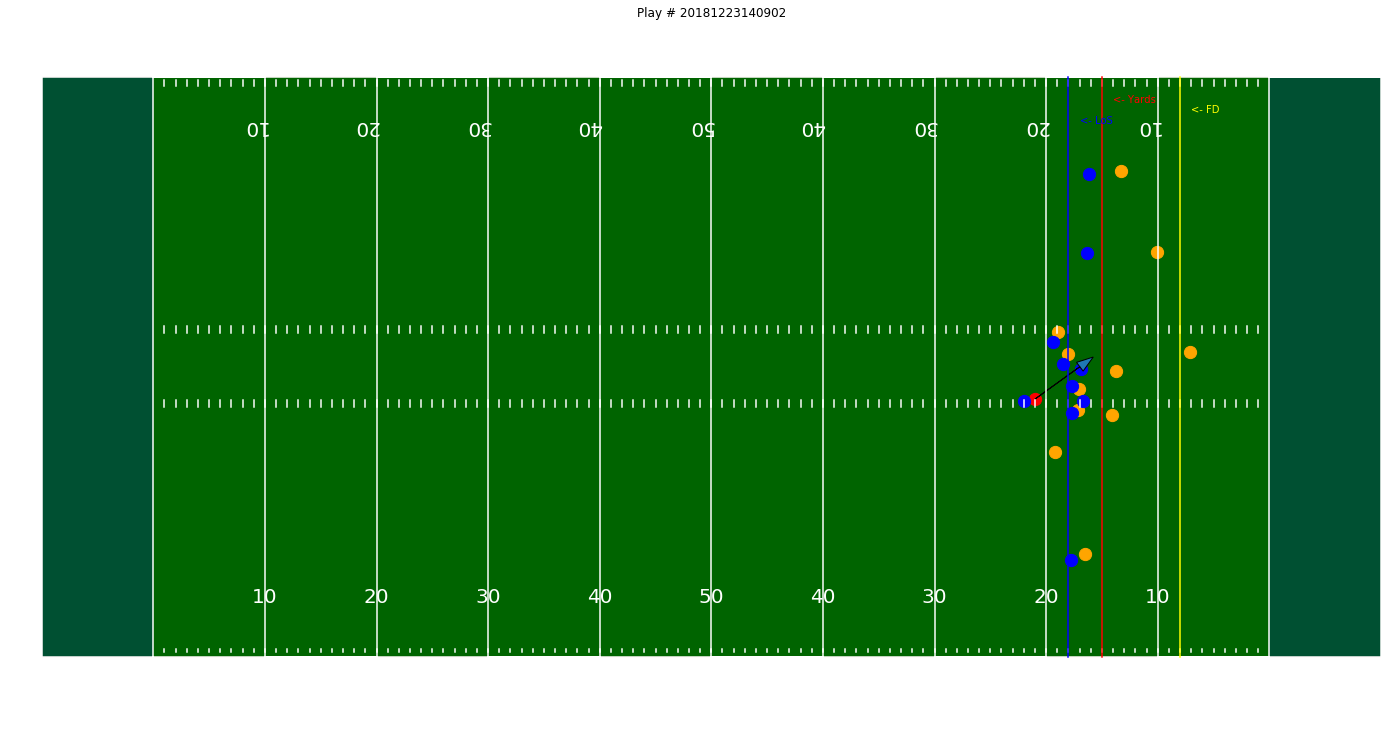

In [500]:
display_play(20181223140902)

In [57]:
train_df

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,S_std,IsRusher,TeamOnOffense,IsOnOffense,ToLeft,YardLine_std,X_std,Y_std,Dir_rad,Dir_std,DisFromPlayStart,RankDisFromPlayStart,IsDefenderInBox,IsFirstAndTen,Y_Std,X_Std
0,2017090700,20170907000118,away,73.91,34.84,1.918039,1.13,0.40,-0.139801,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,1.69,False,home,False,True,35,46.09,-8.173333,4.761607,-1.521578,8.245694,7.0,False,0,18.496667,46.09
1,2017090700,20170907000118,away,74.67,32.64,0.488822,1.35,0.01,-1.088911,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,0.42,False,home,False,True,35,45.33,-5.973333,4.386012,-1.897173,5.982442,4.0,True,0,20.696667,45.33
2,2017090700,20170907000118,away,74.00,33.20,1.389116,0.59,0.31,-1.518262,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,1.22,False,home,False,True,35,46.00,-6.533333,4.315676,-1.967510,6.609421,5.0,True,0,20.136667,46.00
3,2017090700,20170907000118,away,71.46,27.70,0.488822,0.54,0.02,-1.574811,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,0.42,False,home,False,True,35,48.54,-1.033333,6.010216,-0.272969,3.687733,3.0,True,0,25.636667,48.54
4,2017090700,20170907000118,away,69.32,35.42,2.064336,2.43,0.16,-1.350361,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,1.82,False,home,False,True,35,50.68,-8.753333,4.986231,-1.296954,10.434713,9.0,False,0,17.916667,50.68
5,2017090700,20170907000118,away,75.06,24.00,1.152789,0.32,0.18,-2.472433,95.01,2543494,Dee Ford,55,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-2,252,03/19/1991,Auburn,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,1.01,False,home,False,True,35,44.94,2.666667,6.195744,-0.087441,2.667342,2.0,True,0,29.336667,44.94
6,2017090700,20170907000118,away,74.11,16.64,1.265326,0.83,0.02,-1.619142,322.59,2543637,Terrance Mitchell,39,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,5-11,190,05/17/1992,Oregon,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,1.11,False,home,False,True,35,45.89,10.026667,2.223724,2.223724,10.066089,8.0,False,0,36.69